total count of crashes: 263
min injury count: 2
max injury count: 298

count of severe events: 26
count of moderate events: 34
count of minor events: 203

earliest event: 2008-02-08T00:00:00.000000
latest event: 2025-09-30T00:00:00.000000


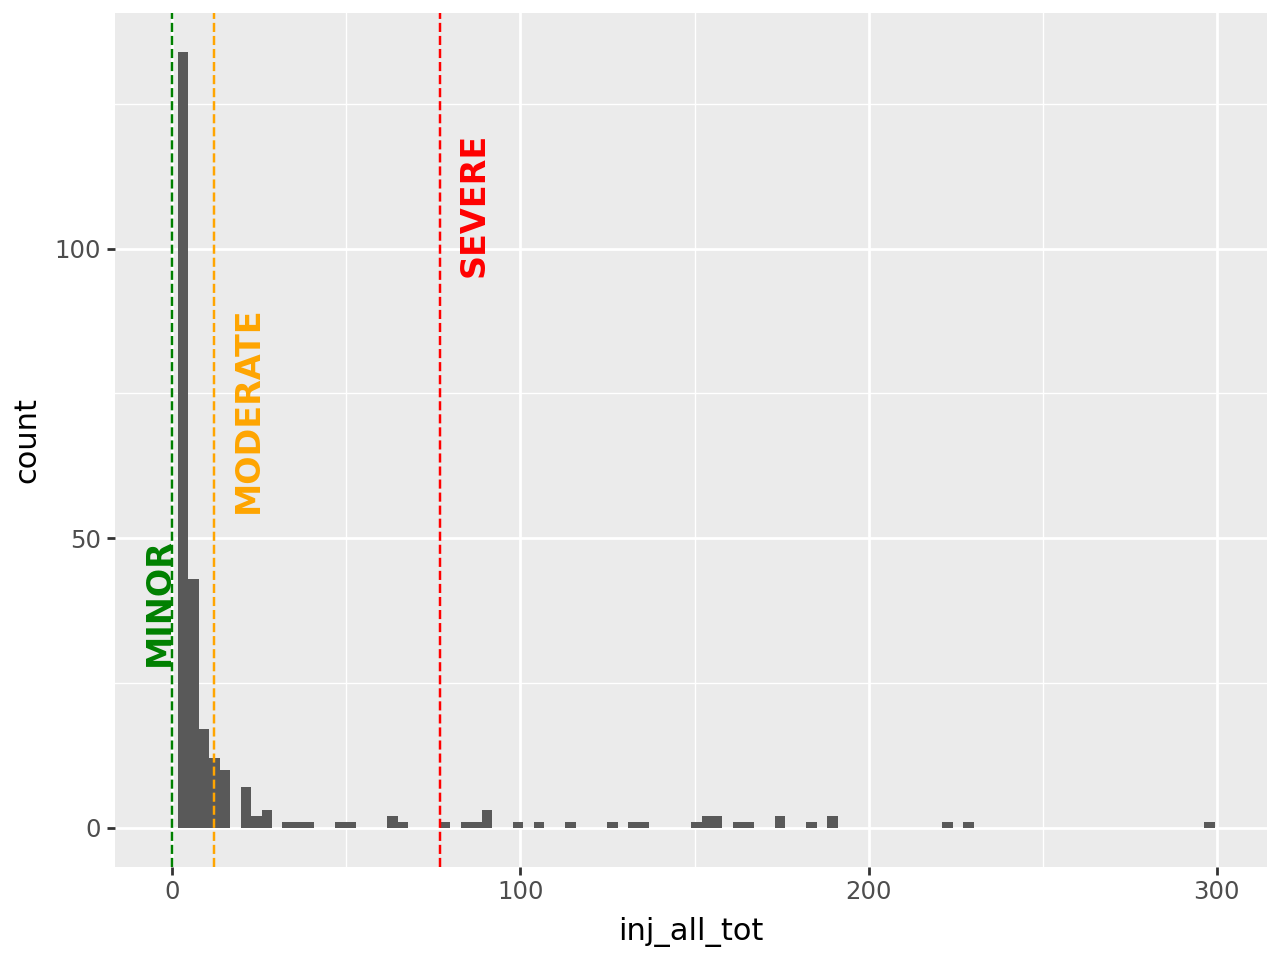

In [9]:
import subprocess, os
import polars as pl
import pandas as pd
from plotnine import *


INJURY_COUNT_THRESH = 1

pl.Config.set_tbl_rows(10000)  # or a large enough number for your table
pl.Config.set_tbl_width_chars(200)  # widen output if needed
pl.Config.set_tbl_cols(100)  # show all columns

# load events
DATA_ROOT = os.path.join(os.getcwd(), "data")
df_events = pl.read_parquet(
    os.path.join(DATA_ROOT, "ntbs/processed.parquet")
).with_columns(pl.col("oper_name").str.strip_chars().str.to_uppercase())
# df_events.write_parquet(os.path.join(DATA_ROOT, "ntbs/processed.parquet"))
SEVERE_THRESH = 77
MODERATE_THRESH = 12
## sorted segmented events
df_severe_events = df_events.filter(pl.col("inj_all_tot") > SEVERE_THRESH).sort(
    "inj_all_tot", descending=True
)
df_moderate_events = df_events.filter(
    (pl.col("inj_all_tot") <= SEVERE_THRESH) & (pl.col("inj_all_tot") > MODERATE_THRESH)
).sort("inj_all_tot", descending=True)
df_minor_events = df_events.filter((pl.col("inj_all_tot") <= MODERATE_THRESH)).sort(
    "inj_all_tot", descending=True
)
print(f"total count of crashes: {len(df_events)}")
print(f"min injury count: {df_events.select('inj_all_tot').min().to_numpy()[0][0]}")
print(f"max injury count: {df_events.select('inj_all_tot').max().to_numpy()[0][0]}")

print(f"\ncount of severe events: {len(df_severe_events)}")
print(f"count of moderate events: {len(df_moderate_events)}")
print(f"count of minor events: {len(df_minor_events)}")
print(f"\nearliest event: {df_events.select('ev_date').min().to_numpy()[0][0]}")
print(f"latest event: {df_events.select('ev_date').max().to_numpy()[0][0]}")
(
    ggplot(df_events, aes(x="inj_all_tot"))
    + geom_histogram(bins=100)
    + geom_vline(xintercept=SEVERE_THRESH, color="red", linetype="dashed")
    + annotate(
        "text",
        x=SEVERE_THRESH + 5,
        y=120,
        label="SEVERE",
        color="red",
        angle=90,
        va="top",
        ha="left",
        size=12,
        fontweight="bold",
    )
    + geom_vline(xintercept=MODERATE_THRESH, color="orange", linetype="dashed")
    + annotate(
        "text",
        x=MODERATE_THRESH + 5,
        y=90,
        label="MODERATE",
        color="orange",
        angle=90,
        va="top",
        ha="left",
        size=12,
        fontweight="bold",
    )
    + geom_vline(xintercept=0, color="green", linetype="dashed")
    + annotate(
        "text",
        x=1,
        y=50,
        label="MINOR",
        color="green",
        angle=90,
        va="top",
        ha="right",
        size=12,
        fontweight="bold",
    )
)

Notes:
- Malaysian airline ticker (most intense crash) is not available via yfinance. It was delisted. But it used to trade and data for it is out there

In [10]:
### ticker convertion maps
MANUFACTURER = {"BOEING", "AIRBUS", "AIRBUS INDUSTRIE"}

TICKER_MAP = {
    "BOEING": "BA",
    "AIRBUS": "EADSY",
    "AIRBUS INDUSTRIE": "EADSY",
    "AIR FRANCE": "AF.PA",
    "ASIANA AIRLINES": "020560.KS",
    "PEGASUS AIRLINES": "PGSUS.IS",
    "JEJU AIR": "089590.KQ",
    "LUFTHANSA": "LHA.DE",
    "SOUTHWEST AIRLINES CO": "LUV",
    "CHINA EASTERN AIRLINES": "CEA",
    "AMERICAN AIRLINES INC.,": "AAL",
    "AMERICAN AIRLINES INC": "AAL",
    "UNITED AIRLINES": "UAL",
    "UNITED AIR LINES INC": "UAL",
    "JETBLUE AIRWAYS": "JBLU",
    "LATAM": "LTM",
    "AIR CANADA": "AC",
    "SINGAPORE AIRLINES LTD": "C6L",
    "SINGAPORE AIRLINES": "C6L",
    "CHINA AIRLINES": "2610",
    "AIR INDIA CHARTERS": "BLUEDART.NS",
    # --- Appended airline tickers from larger list ---
    "ALASKA AIRLINES INC": "ALK",
    "NORWEGIAN AIR SHUTTLE SWEDEN A": "NAS.OL",
    "SOUTHWEST AIRLINES CO": "LUV",
    "SPIRIT AIRLINES LLC": "SAVEQ",
    "SPIRIT AIRLINES": "SAVEQ",
    "SPIRIT AIRLINES, INC.": "SAVEQ",
    "SPIRIT AIRLINES INC.": "SAVEQ",
    "SPIRIT AIRLINES INC": "SAVEQ",
    "ASIANA AIRLINES": "020560.KS",
    "ALLEGIANT AIR, LLC": "ALGT",
    "DELTA AIR LINES, INC.": "DAL",
    "DELTA AIR LINES INC": "DAL",
    "DELTA AIR LINES": "DAL",
    "DELTA AIR LINES INC": "DAL",
    "DELTA AIRLINES": "DAL",
    "KLM ROYAL DUTCH AIRLINES": "AF.PA",
    "AIR FRANCE": "AF.PA",
    "JAPAN AIRLINES INTERNATIONAL": "9201.T",
    "JAPAN AIRLINES INTERNATIONAL C": "9201.T",
    "UNITED PARCEL SERVICE CO": "UPS",
    "BRITISH AIRWAYS": "IAG.L",
    "BRITISH AIRWAYS": "IAG.L",
    "CATHAY PACIFIC AIRWAYS": "0293.HK",
    "INTERNATIONAL LEASE FINANCE CO": "AER",
    "UTAIR": "UTAR.ME",
    "RYAN AIR": "RYAAY",
    "ANA": "9202.T",
    "ALL NIPPON AIRWAYS": "9202.T",
    "ALL NIPPON AIRWAYS CO. LTD": "9202.T",
}


AIRLINES = list(TICKER_MAP.keys() - MANUFACTURER)

STOCK_MARKET_MAP = {
    "INDIGO.NS": "^NSEI",  # NIFTY 50 (India)
    "BLUEDART.NS": "^NSEI",  # NIFTY 50 (India)
    "BA": "^GSPC",  # S&P 500 (US)
    "GE": "^GSPC",  # S&P 500 (US)
    "EADSY": "^GSPC",  # Airbus ADR trades in US → S&P 500
    "AF.PA": "^FCHI",  # CAC 40 (France)
    "020560.KS": "^KS11",  # Asiana Airlines — KOSPI (Korea)
    "LHA.DE": "^GDAXI",  # Lufthansa — DAX (Germany)
    "LUV": "^GSPC",  # Southwest — S&P 500 (US)
    "PGSUS.IS": "XU100.IS",  # Pegasus — BIST 100 (Turkey)
    "CEA": "^GSPC",  # China Eastern ADR — S&P 500 (US)
    "089590.KQ": "^KQ11",  # JEJU Air — KOSDAQ (Korea)
    "AAL": "^GSPC",  # American Airlines — S&P 500 (US)
    "UAL": "^GSPC",  # United Airlines — S&P 500 (US)
    "JBLU": "^GSPC",  # JetBlue — S&P 500 (US)
    "LTM": "^GSPC",  # LATAM ADR — S&P 500 (US)
    "AC": "^GSPTSE",  # Air Canada — S&P/TSX Composite (Canada)
    "C6L": "^STI",  # Singapore Airlines — Straits Times Index (Singapore)
    "2610": "^TWII",  # China Airlines — TAIEX (Taiwan)
    # --- Appended airline tickers from extended list ---
    "ALK": "^GSPC",  # Alaska Air Group — US
    "NAS.OL": "OBX.OL",  # Norwegian Air Shuttle — Oslo OBX Index
    "SAVEQ": "^GSPC",  # Spirit Airlines — US (OTC but US index applies)
    "ALGT": "^GSPC",  # Allegiant Travel Co — US
    "DAL": "^GSPC",  # Delta Air Lines — US
    "IAG.L": "^FTSE",  # International Airlines Group (British Airways/Aer Lingus) — FTSE 100
    "0293.HK": "^HSI",  # Cathay Pacific — Hang Seng Index (HK)
    "AER": "^GSPC",  # AerCap Holdings (ILFC acquirer) — US
    "UTAR.ME": "IMOEX.ME",  # UTair Aviation — MOEX Russia Index
    "RYAAY": "^GSPC",  # Ryanair ADR — US
    "9202.T": "^N225",  # ANA Holdings — Nikkei 225
    "9201.T": "^N225",  # Japan Airlines — Nikkei 225
    "UPS": "^GSPC",  # United Parcel Service — US
}


#### EVERYTHING BELOW WILL FILTER FOR EVENTS THAT
1. INVOLVE BOEING OR AIR BUS 
2. INVOLVE PUBLICALLY AVAILABLE AIRLINES

In [11]:
df_ev_anal = (
    df_events.filter(
        (pl.col("oper_name").is_in(AIRLINES))
        & (pl.col("acft_make").is_in(MANUFACTURER))
    )
    .select(
        pl.col(
            [
                "ev_date",
                "ev_id",
                "acft_make",
                "oper_name",
                "inj_tot_f",
                "inj_all_tot",
                "ev_city",
                "ev_country",
            ]
        )
    )
    .with_columns(
        manufacturer_tkr=pl.col("acft_make").map_elements(
            lambda s: TICKER_MAP.get(s, None), return_dtype=pl.Utf8
        ),
        airline_tkr=pl.col("oper_name").map_elements(
            lambda s: TICKER_MAP.get(s, None), return_dtype=pl.Utf8
        ),
        category=pl.when(pl.col("inj_all_tot") > SEVERE_THRESH)
        .then(pl.lit("severe"))
        .when(pl.col("inj_all_tot") <= MODERATE_THRESH)
        .then(pl.lit("minor"))
        .otherwise(pl.lit("moderate")),
    )
    .with_columns(
        market_tkr=pl.col("airline_tkr").map_elements(
            lambda s: STOCK_MARKET_MAP.get(s, None), return_dtype=pl.Utf8
        )
    )
).sort("ev_date", descending=False)
## sorted segmented events
df_severe_ev_anal = df_ev_anal.filter(pl.col("category").eq(pl.lit("severe")))
df_moderate_ev_anal = df_ev_anal.filter(pl.col("category").eq(pl.lit("moderate")))
df_minor_ev_anal = df_ev_anal.filter(pl.col("category").eq(pl.lit("minor")))
print(f"total count of crashes: {len(df_ev_anal)}")
print(f"min injury count: {df_ev_anal.select('inj_all_tot').min().to_numpy()[0][0]}")
print(f"max injury count: {df_ev_anal.select('inj_all_tot').max().to_numpy()[0][0]}")

print(f"\ncount of severe events: {len(df_severe_ev_anal)}")
print(f"count of moderate events: {len(df_moderate_ev_anal)}")
print(f"count of minor events: {len(df_minor_ev_anal)}")
print(f"\nearliest event: {df_ev_anal.select('ev_date').min().to_numpy()[0][0]}")
print(f"latest event: {df_ev_anal.select('ev_date').max().to_numpy()[0][0]}")

total count of crashes: 93
min injury count: 2
max injury count: 228

count of severe events: 8
count of moderate events: 12
count of minor events: 73

earliest event: 2008-10-02T00:00:00.000000
latest event: 2025-09-30T00:00:00.000000


##### functions to compute metrics

In [12]:
PRICE_CACHE = pl.read_parquet(os.path.join(DATA_ROOT, "stocks/price_cache.parquet"))
CAR_CACHE = pl.read_parquet(os.path.join(DATA_ROOT, "stocks/car_cache.parquet"))

In [13]:
import yfinance as yf
from datetime import datetime, date


def load_tkr_price(ticker: str, start: datetime, end: datetime) -> pl.DataFrame:
    """

    Parameters
    ----------
    ticker : str
    start : str 'YYYY-MM-DD'
    end : str 'YYYY-MM-DD'
    cache : dict or None
        If provided, cache[(ticker, start, end)] stores the DataFrame.

    Returns
    -------
    modifies cache
    """
    global PRICE_CACHE
    start = start.date() if isinstance(start, datetime) else start
    end = end.date() if isinstance(end, datetime) else end

    # 1) Serve from cache if exists
    target_cache = PRICE_CACHE.filter(pl.col("tkr").eq(pl.lit(ticker))).sort("date")
    if target_cache.height != 0:
        min_d = target_cache.select(pl.col("date").min()).to_numpy()[0][0]

        max_d = target_cache.select(pl.col("date").max()).to_numpy()[0][0]
        if (min_d <= start) and (max_d >= end):
            print(f"using cache for {ticker} between {start}  ->  {end}")
            return target_cache.filter(
                (pl.col("date") >= start) & (pl.col("date") <= end)
            )

    # 2) Fetch from Yahoo Finance
    df = yf.Ticker(ticker).history(start=start, end=end, auto_adjust=True)

    if df.empty:
        raise ValueError(
            f"No price data returned for {ticker} between {start} and {end}"
        )

    # 3) Convert to Polars
    out = (
        pl.DataFrame(df.reset_index()[["Date", "Close"]])
        .rename({"Date": "date", "Close": "close"})
        .with_columns(
            pl.col("date").cast(pl.Date),
            pl.col("close").cast(pl.Float64),
            tkr=pl.lit(ticker),
        )
        .sort("date")
    )

    PRICE_CACHE = (
        pl.concat([PRICE_CACHE, out], how="vertical")  # out last so it's preferred
        .unique(subset=["date", "tkr"], keep="last")
        .sort("date")
    )

    return out


In [14]:
## pre load manufacturer prices for entire window (2008 - 2025)

# for manu in MANUFACTURER:
#     manu_tkr = TICKER_MAP.get(manu, None)
#     if manu_tkr is None:
#         print("couldnt fetch ticker from map")
#         continue
#     load_tkr_price("BA", start=date(2008, 2, 10), end=date(2025, 9, 30))

In [15]:
import numpy as np
from datetime import timedelta


def compute_car(
    event_id: str,
    event_date: date | datetime,
    stock_tkr: str,
    market_tkr: str,
    est_window=(-120, -21),
    evt_window=(-5, 20),
    stock_type=None,
):
    global PRICE_CACHE

    # ---- Normalize event date ----
    event_date = event_date.date() if isinstance(event_date, datetime) else event_date

    # ---- Compute stock event-window fetch range ----
    stock_start = event_date + timedelta(days=evt_window[0])
    stock_end = event_date + timedelta(days=evt_window[1])
    stock_df = (
        load_tkr_price(stock_tkr, stock_start, stock_end)
        .rename({"close": "stock"})
        .sort("date")
    )

    # ---- Compute market estimation-window fetch range ----
    est_start = event_date + timedelta(days=est_window[0])
    est_end = event_date + timedelta(days=est_window[1])
    mkt_est = (
        load_tkr_price(market_tkr, est_start, est_end)
        .rename({"close": "mkt"})
        .sort("date")
    )

    # ---- Market event window (needed for expected returns on event window) ----
    mkt_evt = (
        load_tkr_price(market_tkr, stock_start, stock_end)
        .rename({"close": "mkt"})
        .sort("date")
    )

    # ---- 1) Compute estimation-window returns ----
    mkt_est = mkt_est.with_columns(
        pl.col("mkt").pct_change().alias("r_mkt")
    ).drop_nulls()
    # need stock returns in estimation window → fetch stock too
    stock_est = (
        load_tkr_price(stock_tkr, est_start, est_end)
        .rename({"close": "stock"})
        .sort("date")
    )
    stock_est = stock_est.with_columns(
        pl.col("stock").pct_change().alias("r_stock")
    ).drop_nulls()

    # align estimation windows by date
    df_est = stock_est.join(mkt_est, on="date", how="inner")

    Ri = df_est["r_stock"].to_numpy()
    Rm = df_est["r_mkt"].to_numpy()

    # ---- 2) OLS market model ----
    X = np.column_stack([np.ones(len(Rm)), Rm])
    alpha, beta = np.linalg.lstsq(X, Ri, rcond=None)[0]

    # ---- 3) Compute AR for event window ----
    stock_evt = stock_df.with_columns(
        pl.col("stock").pct_change().alias("r_stock")
    ).drop_nulls()
    mkt_evt = mkt_evt.with_columns(
        pl.col("mkt").pct_change().alias("r_mkt")
    ).drop_nulls()

    df_evt = stock_evt.join(mkt_evt, on="date", how="inner")

    df_evt = df_evt.with_columns(
        [(pl.col("r_stock") - (alpha + beta * pl.col("r_mkt"))).alias("AR")]
    )

    df_evt = df_evt.with_columns(pl.col("AR").cum_sum().alias("CAR"))
    return df_evt.select(["date", "AR", "CAR", "tkr"]).with_columns(
        ev_id=pl.lit(event_id),
        stock_type=pl.lit(stock_type),
        flavor=pl.when(
            (pl.col("date") >= pl.lit(event_date - timedelta(days=5)))
            & (pl.col("date") <= pl.lit(event_date + timedelta(days=5)))
        )
        .then(pl.lit("short"))
        .otherwise(pl.lit("extended")),
    )


In [16]:
def compute_car_all(data: pl.DataFrame) -> list[dict]:
    global CAR_CACHE
    err = []
    for row in data.to_dicts():
        stock_tkr = TICKER_MAP.get(row["acft_make"])
        mkt_tkr = STOCK_MARKET_MAP.get(stock_tkr)

        if stock_tkr and mkt_tkr:
            try:
                res_manu = compute_car(
                    event_id=row["ev_id"],
                    event_date=row["ev_date"],
                    stock_tkr=stock_tkr,
                    market_tkr=mkt_tkr,
                    stock_type="manufacturer",
                )
                CAR_CACHE = (
                    pl.concat([CAR_CACHE, res_manu])
                    .unique(subset=["date", "tkr", "ev_id"], keep="last")
                    .sort("date")
                ).sort(["ev_id", "stock_type", "date"])
            except ValueError as e:
                err.append(row | {"stock_type": "manufacturer"})
                print(f"⚠️  Skipping manufacturer {stock_tkr} for {row['ev_id']}: {e}")

        stock_tkr = TICKER_MAP.get(row["oper_name"])
        mkt_tkr = STOCK_MARKET_MAP.get(stock_tkr)

        if stock_tkr and mkt_tkr:
            try:
                res_oper = compute_car(
                    event_id=row["ev_id"],
                    event_date=row["ev_date"],
                    stock_tkr=stock_tkr,
                    market_tkr=mkt_tkr,
                    stock_type="operator",
                )
                CAR_CACHE = (
                    pl.concat([CAR_CACHE, res_oper])
                    .unique(subset=["date", "tkr", "ev_id"], keep="last")
                    .sort("date")
                ).sort(["ev_id", "stock_type", "date"])
            except ValueError as e:
                err.append(row | {"stock_type": "operator"})
                print(f"⚠️  Skipping operator {stock_tkr} for {row['ev_id']}: {e}")
    print(f"Total CAR records computed: {CAR_CACHE.height}")
    return err


In [17]:
### computing CAR

# CAR_CACHE = pl.DataFrame(
#     schema={
#         "date": pl.Date,
#         "AR": pl.Float64,
#         "CAR": pl.Float64,
#         "tkr": pl.Utf8,
#         "ev_id": pl.Utf8,
#         "stock_type": pl.Utf8,
#         "flavor": pl.Utf8,
#     }
# )
# err = compute_car_all(data=df_severe_ev_anal)
# err.extend(compute_car_all(data=df_moderate_ev_anal))
# err.extend(compute_car_all(data=df_minor_ev_anal))
# err
# CAR_CACHE.write_parquet(os.path.join(DATA_ROOT, "stocks/car_cache.parquet"))

In [18]:
CAR_CACHE.head(10)

date,AR,CAR,tkr,ev_id,stock_type,flavor
date,f64,f64,str,str,str,str
2009-03-02,-0.011934,-0.011934,"""BA""","""20090305X25029""","""manufacturer""","""short"""
2009-03-03,0.003093,-0.008841,"""BA""","""20090305X25029""","""manufacturer""","""short"""
2009-03-04,0.009575,0.000734,"""BA""","""20090305X25029""","""manufacturer""","""short"""
2009-03-05,0.014904,0.015638,"""BA""","""20090305X25029""","""manufacturer""","""short"""
2009-03-06,0.024509,0.040148,"""BA""","""20090305X25029""","""manufacturer""","""short"""
2009-03-09,0.041789,0.081937,"""BA""","""20090305X25029""","""manufacturer""","""short"""
2009-03-10,0.001091,0.083028,"""BA""","""20090305X25029""","""manufacturer""","""extended"""
2009-03-11,0.006966,0.089994,"""BA""","""20090305X25029""","""manufacturer""","""extended"""
2009-03-12,-0.029386,0.060608,"""BA""","""20090305X25029""","""manufacturer""","""extended"""


In [19]:
## compute car_min, car_max, signed_mae

MAE_CACHE = (
    CAR_CACHE.filter(pl.col("flavor").eq(pl.lit("short")))
    .group_by(["ev_id", "tkr", "stock_type"])
    .agg(
        [
            pl.col("CAR").min().alias("CAR_min"),  # most negative (worst loss)
            pl.col("CAR").max().alias("CAR_max"),  # most positive (best gain)
        ]
    )
    .with_columns(
        [
            pl.when(pl.col("CAR_max").abs() >= pl.col("CAR_min").abs())
            .then(pl.col("CAR_max"))
            .otherwise(pl.col("CAR_min"))
            .alias("MAE_signed"),  # max |CAR|, with sign
        ]
    )
)

MAE_CACHE.write_parquet(os.path.join(DATA_ROOT, "stocks/mae_cache.parquet"))
MAE_CACHE

ev_id,tkr,stock_type,CAR_min,CAR_max,MAE_signed
str,str,str,f64,f64,f64
"""20200205X32547""","""BA""","""manufacturer""",-0.008323,0.076672,0.076672
"""20200205X32547""","""PGSUS.IS""","""operator""",-0.033244,0.062697,0.062697
"""20100222X84927""","""UAL""","""operator""",-0.025866,0.062827,0.062827
"""20220321104807""","""BA""","""manufacturer""",-0.053761,-0.009017,-0.053761
"""20250124199591""","""BA""","""manufacturer""",-0.006106,0.018056,0.018056
"""20241229199476""","""BA""","""manufacturer""",-0.043762,0.01249,-0.043762
"""20250623200379""","""BA""","""manufacturer""",-0.02226,-0.007113,-0.02226
"""20250828200898""","""DAL""","""operator""",0.000036,0.020663,0.020663
"""20100312X84023""","""DAL""","""operator""",0.010907,0.059782,0.059782


In [20]:
def compute_TTR(
    CAR_CACHE: pl.DataFrame,
    MAE_CACHE: pl.DataFrame,
    df_ev_anal: pl.DataFrame,
    ttr_default: int = 21,
):
    # copies only — no mutation
    car = CAR_CACHE.clone()
    mae = MAE_CACHE.clone()
    ev = df_ev_anal.clone()

    # bring in event date
    mae = mae.join(ev.select(["ev_id", "ev_date"]), on="ev_id", how="left")

    # join MAE + event_date onto CAR rows
    car = (
        car.join(
            mae.select(["ev_id", "tkr", "stock_type", "MAE_signed", "ev_date"]),
            on=["ev_id", "tkr", "stock_type"],
            how="left",
        )
        .with_columns(
            (pl.col("date") - pl.col("ev_date")).dt.total_days().alias("rel_day")
        )
        .sort(["ev_id", "tkr", "stock_type", "rel_day"])
    )

    results = []

    # ---- iterate over groups (simplest & works everywhere) ----
    unique_groups = car.select(["ev_id", "tkr", "stock_type"]).unique().iter_rows()

    for ev_id, tkr, stock_type in unique_groups:
        # slice group + ensure rel_day >= 0
        df = (
            car.filter(
                (pl.col("ev_id") == ev_id)
                & (pl.col("tkr") == tkr)
                & (pl.col("stock_type") == stock_type)
            )
            .sort("rel_day")
            .filter(pl.col("rel_day") >= 0)  # <<< IMPORTANT FIX
        )

        # if empty, default-out
        if df.height == 0:
            results.append([ev_id, tkr, stock_type, ttr_default, ttr_default])
            continue

        mae_val = df["MAE_signed"][0]

        # handle MAE == None
        if mae_val is None:
            results.append([ev_id, tkr, stock_type, ttr_default, ttr_default])
            continue

        # ---- FULL RECOVERY ----
        if mae_val < 0:
            cond_full = df["CAR"] >= 0
        else:
            cond_full = df["CAR"] <= 0

        # ---- HALF RECOVERY (50% toward zero) ----
        half_target = mae_val * 0.5
        if mae_val < 0:
            cond_half = df["CAR"] >= half_target
        else:
            cond_half = df["CAR"] <= half_target

        # numpy arrays
        cond_full_np = cond_full.to_numpy()
        cond_half_np = cond_half.to_numpy()

        idx_full = np.where(cond_full_np)[0]
        idx_half = np.where(cond_half_np)[0]

        # safe indexing (convert numpy int -> python int)
        TTR_full = (
            int(df["rel_day"][int(idx_full[0])]) if len(idx_full) else ttr_default
        )
        TTR_half = (
            int(df["rel_day"][int(idx_half[0])]) if len(idx_half) else ttr_default
        )

        results.append([ev_id, tkr, stock_type, TTR_full, TTR_half])

    return pl.DataFrame(
        results,
        schema=["ev_id", "tkr", "stock_type", "TTR_full", "TTR_half"],
    )


In [21]:
TTR_CACHE = compute_TTR(CAR_CACHE, MAE_CACHE, df_ev_anal)
TTR_CACHE.write_parquet(os.path.join(DATA_ROOT, "stocks/ttr_cache.parquet"))

/tmp/ipykernel_2521/2958167940.py:87: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.


#### Below is analysis using all the metrics computed. Results from above are stored in caches

In [22]:
CAR_CACHE.describe()

statistic,date,AR,CAR,tkr,ev_id,stock_type,flavor
str,str,f64,f64,str,str,str,str
"""count""","""1059""",1059.0,1059.0,"""1059""","""1059""","""1059""","""1059"""
"""null_count""","""0""",0.0,0.0,"""0""","""0""","""0""","""0"""
"""mean""","""2019-04-06 05:10:01.699000""",0.000304,-0.00585,null,null,null,null
"""std""",null,0.025818,0.097881,null,null,null,null
"""min""","""2009-03-02""",-0.149356,-0.702943,"""020560.KS""","""20090305X25029""","""manufacturer""","""extended"""
"""25%""","""2013-07-05""",-0.011237,-0.040653,null,null,null,null
"""50%""","""2020-02-23""",-0.000831,-0.00481,null,null,null,null
"""75%""","""2025-02-26""",0.01093,0.028773,null,null,null,null
"""max""","""2025-10-17""",0.189247,0.745433,"""UTAR.ME""","""20251003201780""","""operator""","""short"""


In [23]:
MAE_CACHE.describe()

statistic,ev_id,tkr,stock_type,CAR_min,CAR_max,MAE_signed
str,str,str,str,f64,f64,f64
"""count""","""65""","""65""","""65""",65.0,65.0,65.0
"""null_count""","""0""","""0""","""0""",0.0,0.0,0.0
"""mean""",null,null,null,-0.032953,0.025034,-0.007006
"""std""",null,null,null,0.043658,0.047894,0.074827
"""min""","""20090305X25029""","""020560.KS""","""manufacturer""",-0.212603,-0.040004,-0.212603
"""25%""",null,null,null,-0.061683,-0.00445,-0.061683
"""50%""",null,null,null,-0.02226,0.012046,-0.019535
"""75%""",null,null,null,-0.005154,0.034617,0.032138
"""max""","""20251003201780""","""UTAR.ME""","""operator""",0.054714,0.267964,0.267964


In [24]:
TTR_CACHE.describe()

statistic,ev_id,tkr,stock_type,TTR_full,TTR_half
str,str,str,str,f64,f64
"""count""","""73""","""73""","""73""",73.0,73.0
"""null_count""","""0""","""0""","""0""",0.0,0.0
"""mean""",null,null,null,15.082192,8.452055
"""std""",null,null,null,8.420797,9.242176
"""min""","""20090305X25029""","""020560.KS""","""manufacturer""",0.0,0.0
"""25%""",null,null,null,7.0,1.0
"""50%""",null,null,null,21.0,3.0
"""75%""",null,null,null,21.0,21.0
"""max""","""20251003201780""","""UTAR.ME""","""operator""",21.0,21.0


In [25]:
df_ev_anal.describe()

statistic,ev_date,ev_id,acft_make,oper_name,inj_tot_f,inj_all_tot,ev_city,ev_country,manufacturer_tkr,airline_tkr,category,market_tkr
str,str,str,str,str,f64,f64,str,str,str,str,str,str
"""count""","""93""","""93""","""93""","""93""",93.0,93.0,"""93""","""93""","""93""","""93""","""93""","""93"""
"""null_count""","""0""","""0""","""0""","""0""",0.0,0.0,"""0""","""0""","""0""","""0""","""0""","""0"""
"""mean""","""2017-08-28 14:27:05.806451""",null,null,null,9.193548,20.075269,null,null,null,null,null,null
"""std""",null,null,null,null,38.949872,47.37162,null,null,null,null,null,null
"""min""","""2008-10-02 00:00:00""","""20081020X72910""","""AIRBUS""","""AIR CANADA""",0.0,2.0,"""Anchorage""","""AR""","""BA""","""020560.KS""","""minor""","""IMOEX.ME"""
"""25%""","""2011-10-17 00:00:00""",null,null,null,0.0,2.0,null,null,null,null,null,null
"""50%""","""2017-05-22 00:00:00""",null,null,null,0.0,4.0,null,null,null,null,null,null
"""75%""","""2024-03-09 00:00:00""",null,null,null,0.0,8.0,null,null,null,null,null,null
"""max""","""2025-09-30 00:00:00""","""20251003201780""","""BOEING""","""UTAIR""",228.0,228.0,"""Yuma""","""USA""","""EADSY""","""UTAR.ME""","""severe""","""^TWII"""


##### MAE closer look

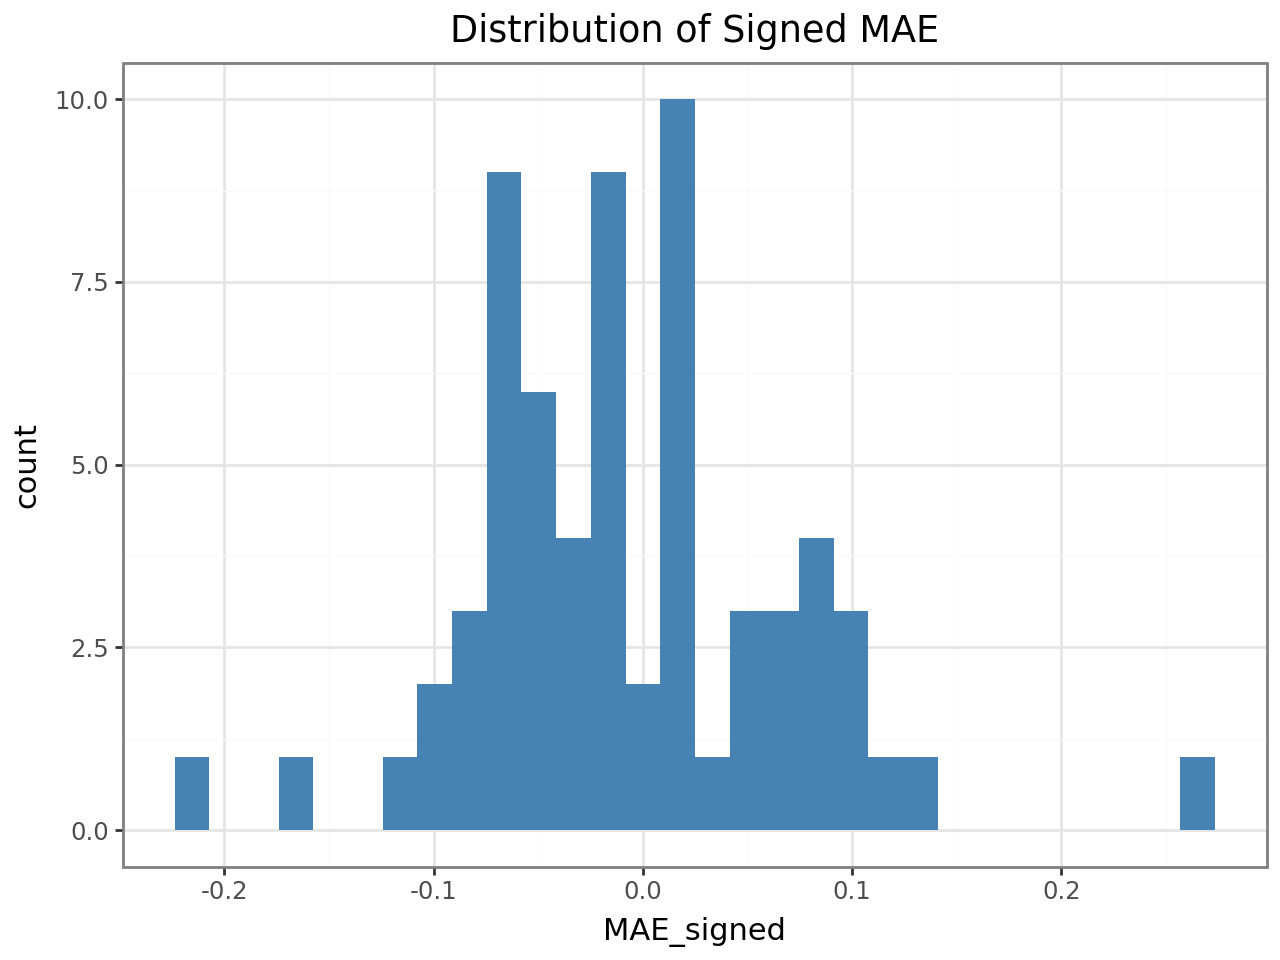

In [26]:
df = MAE_CACHE.join(df_ev_anal, on="ev_id", how="left")
(
    ggplot(df, aes("MAE_signed"))
    + geom_histogram(bins=30, fill="steelblue")
    + theme_bw()
    + labs(title="Distribution of Signed MAE")
)


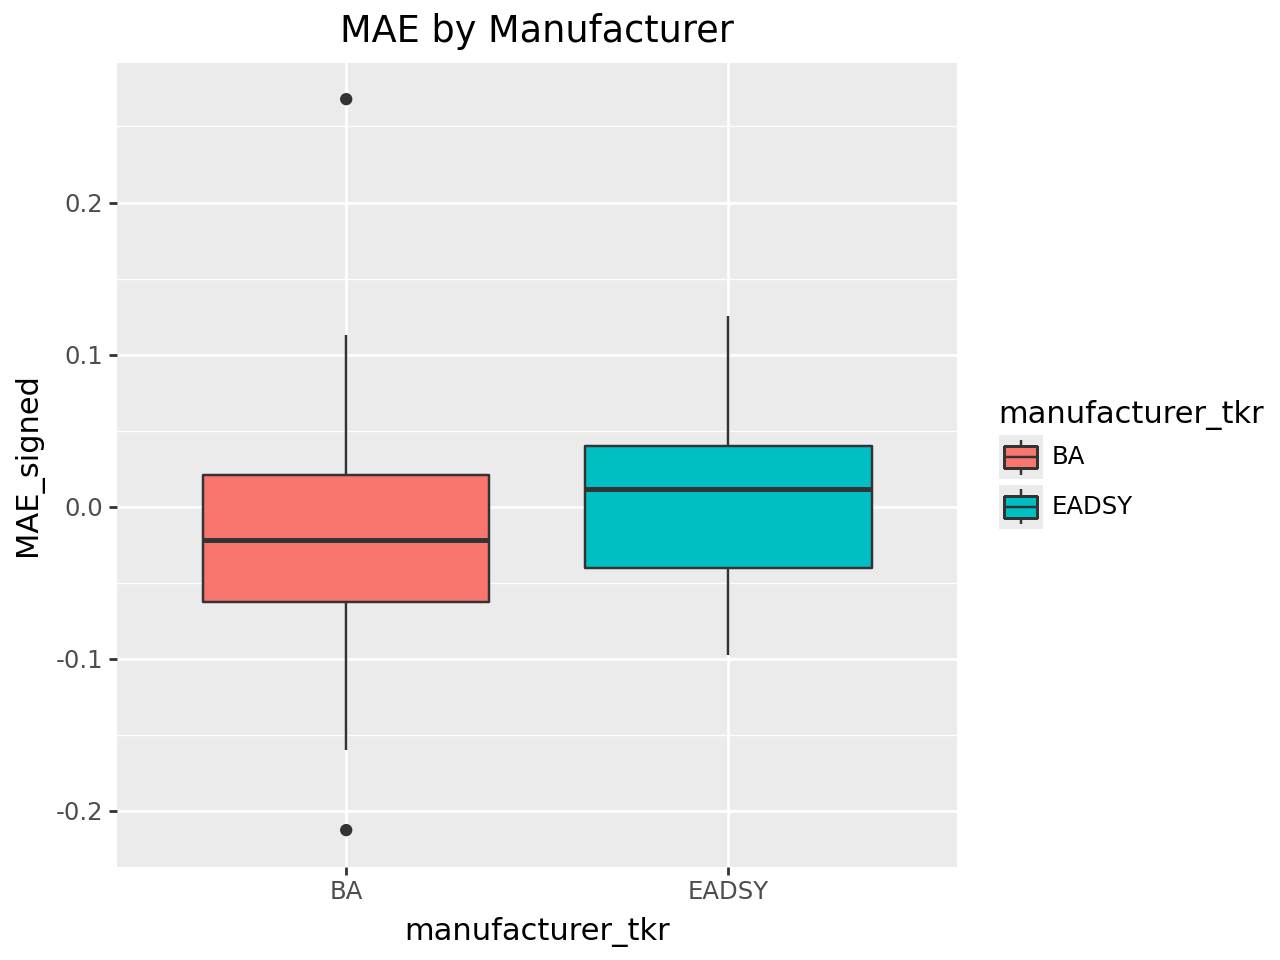

In [27]:
(
    ggplot(df, aes("manufacturer_tkr", "MAE_signed", fill="manufacturer_tkr"))
    + geom_boxplot()
    + labs(title="MAE by Manufacturer")
)


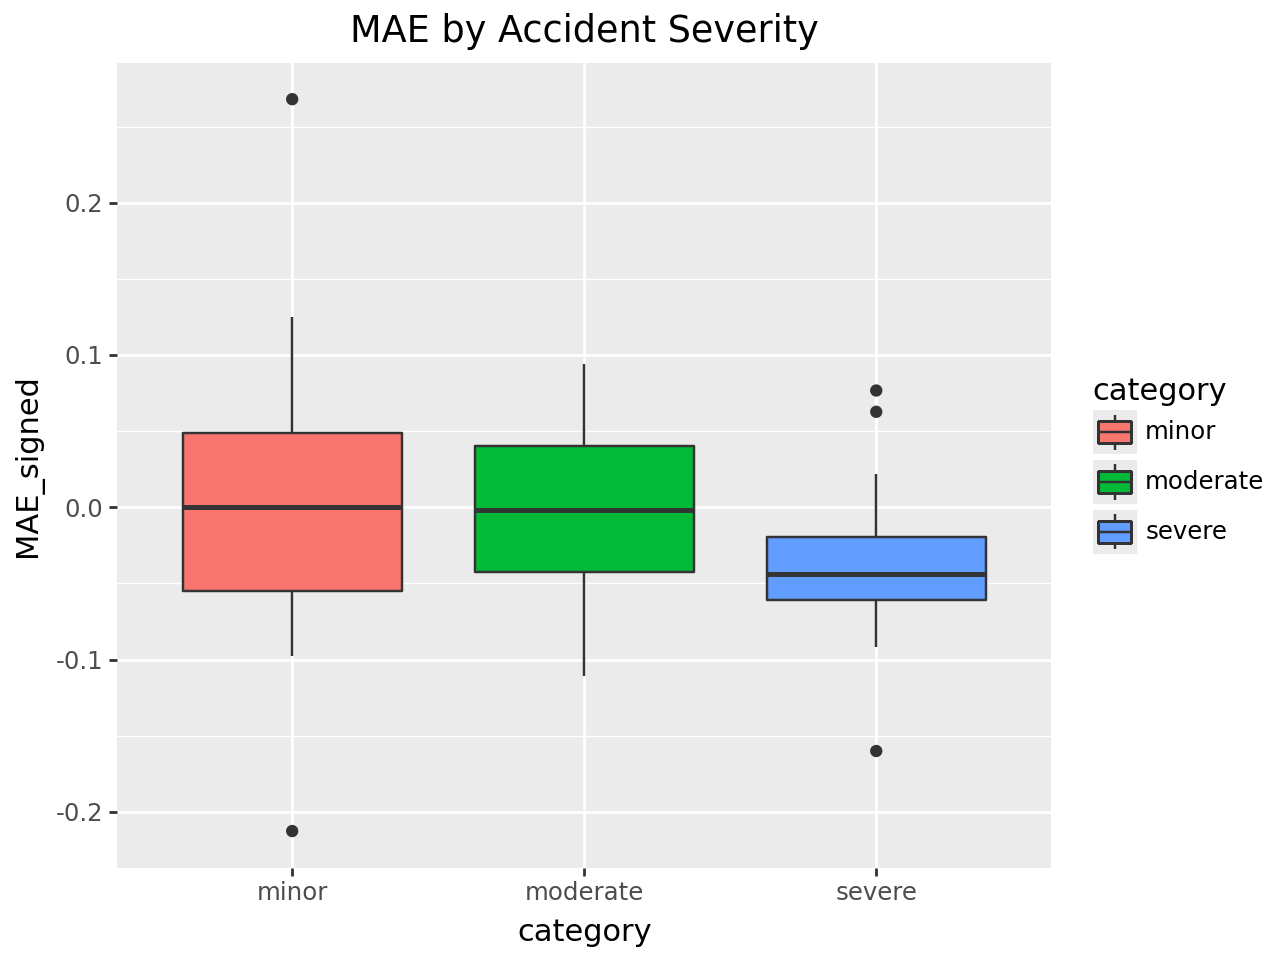

In [28]:
(
    ggplot(df, aes("category", "MAE_signed", fill="category"))
    + geom_boxplot()
    + labs(title="MAE by Accident Severity")
)


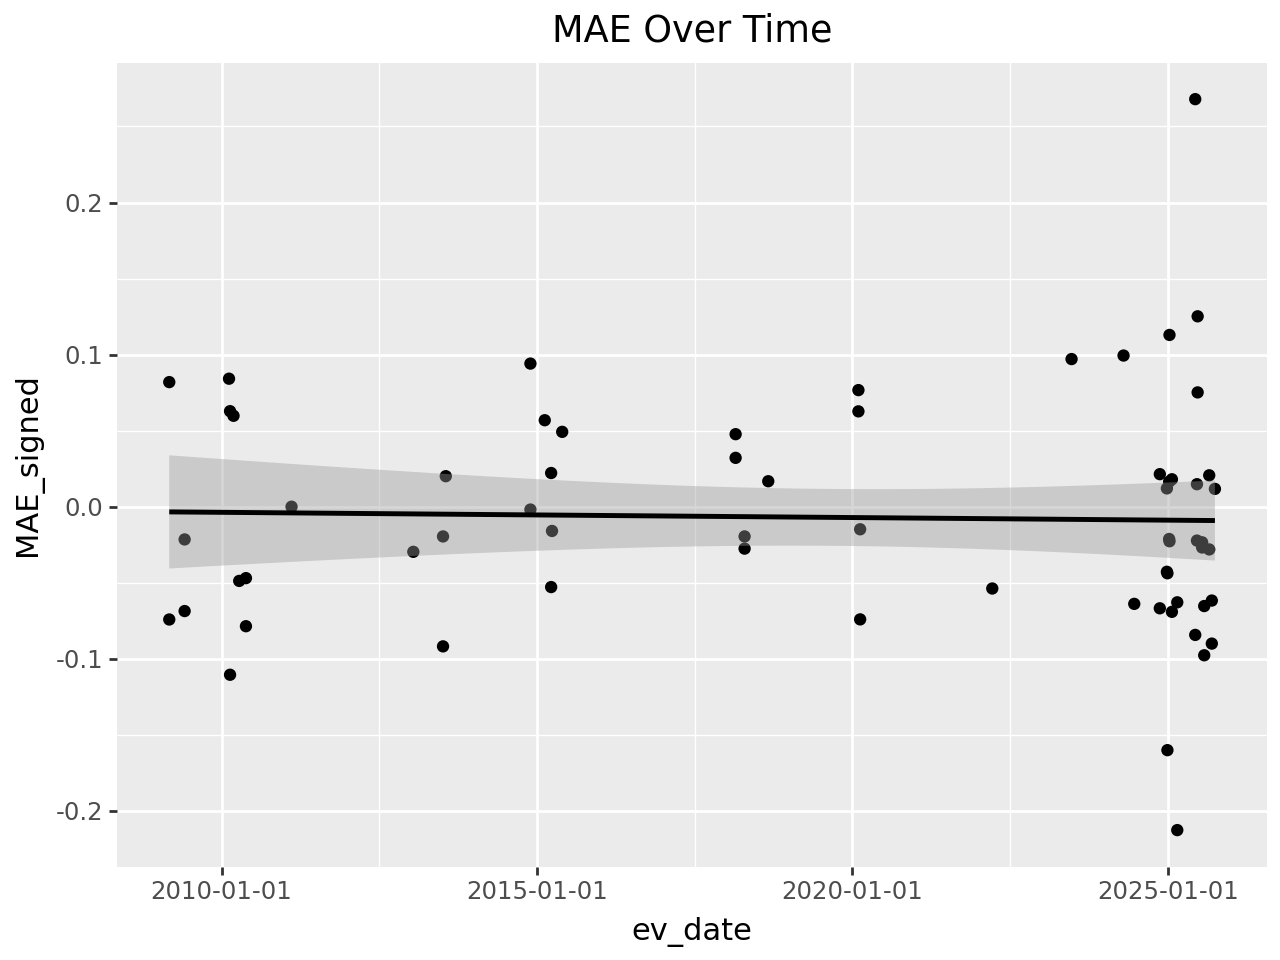

In [29]:
(
    ggplot(df, aes("ev_date", "MAE_signed"))
    + geom_point()
    + geom_smooth(method="lm")
    + labs(title="MAE Over Time")
)


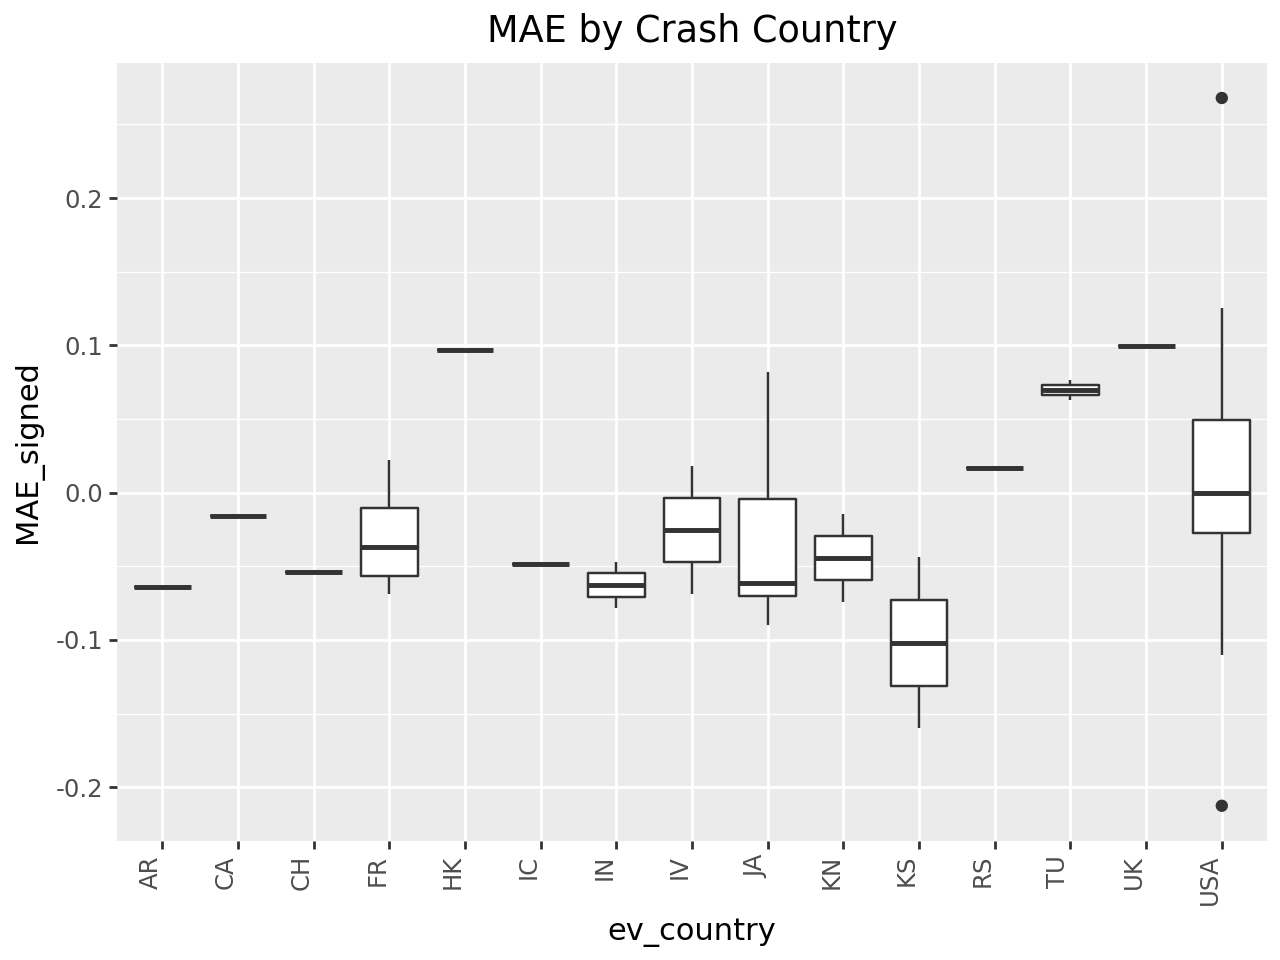

In [30]:
(
    ggplot(df, aes("ev_country", "MAE_signed"))
    + geom_boxplot()
    + theme(axis_text_x=element_text(rotation=90, hjust=1))
    + labs(title="MAE by Crash Country")
)


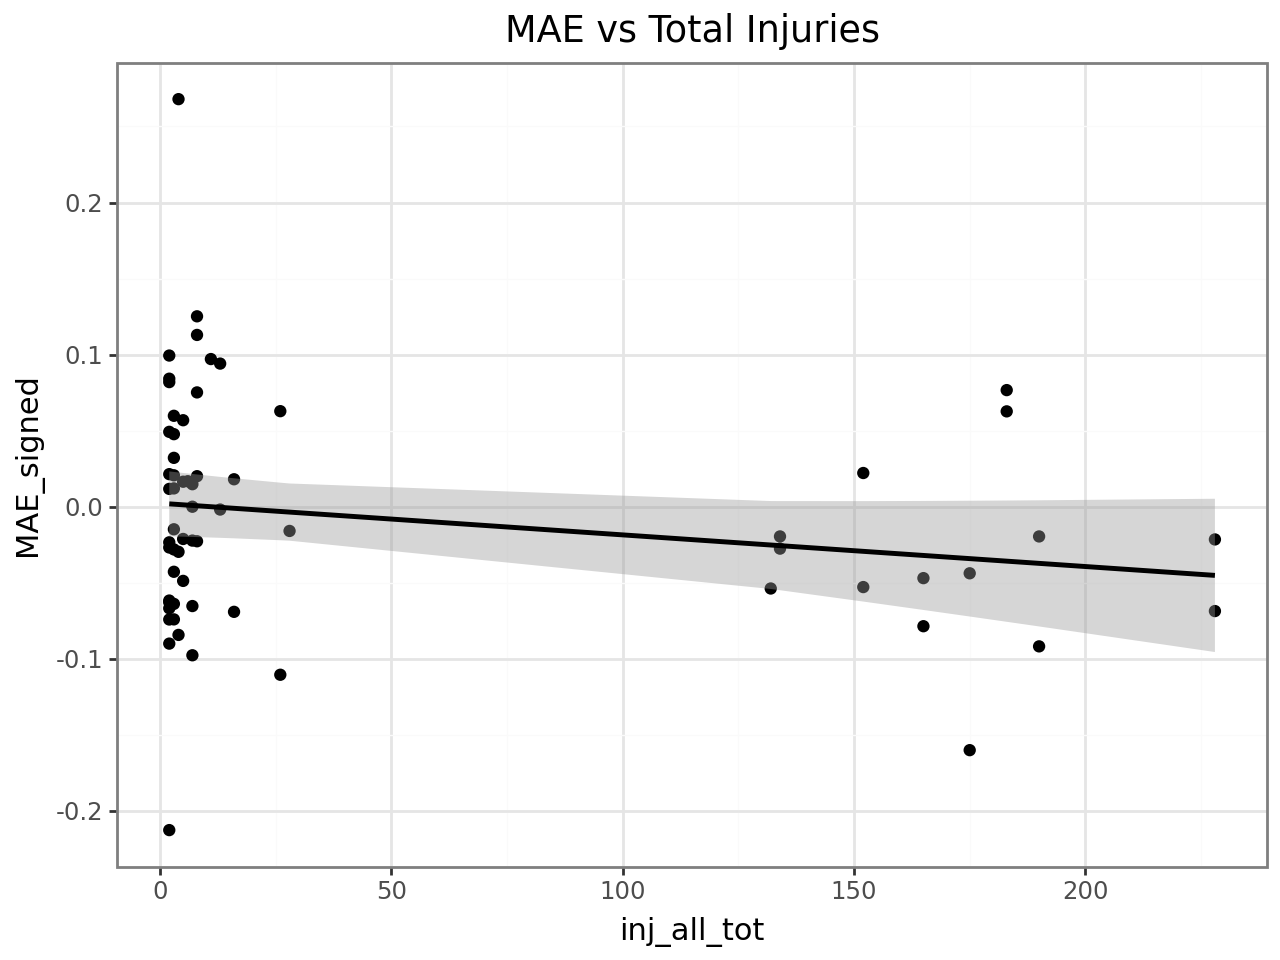

In [31]:
(
    ggplot(df, aes("inj_all_tot", "MAE_signed"))
    + geom_point()
    + geom_smooth(method="lm")
    + theme_bw()
    + labs(title="MAE vs Total Injuries")
)


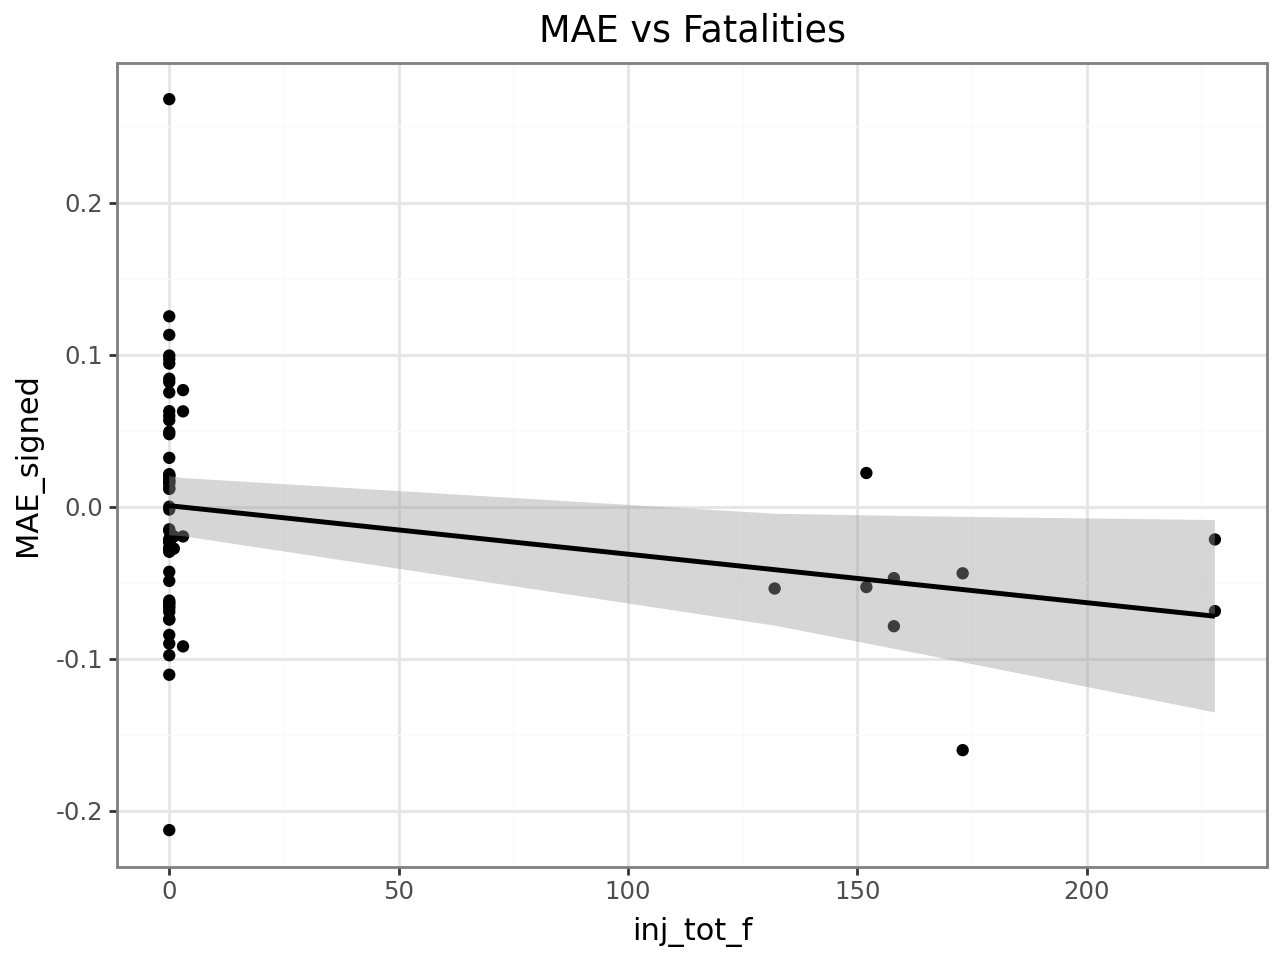

In [32]:
(
    ggplot(df, aes("inj_tot_f", "MAE_signed"))
    + geom_point()
    + geom_smooth(method="lm")
    + theme_bw()
    + labs(title="MAE vs Fatalities")
)


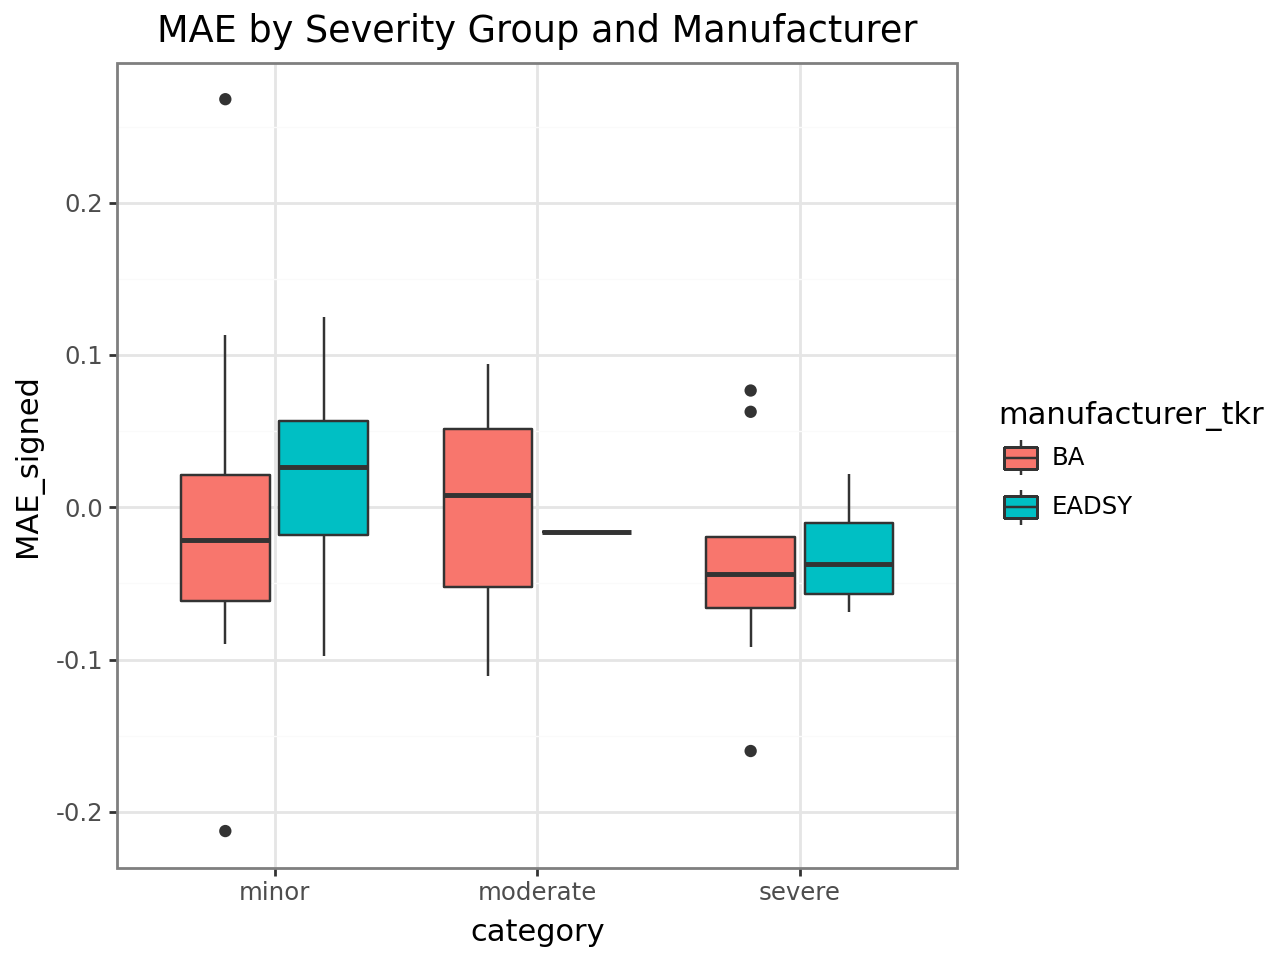

In [33]:
(
    ggplot(df, aes("category", "MAE_signed", fill="manufacturer_tkr"))
    + geom_boxplot()
    + theme_bw()
    + labs(title="MAE by Severity Group and Manufacturer")
)


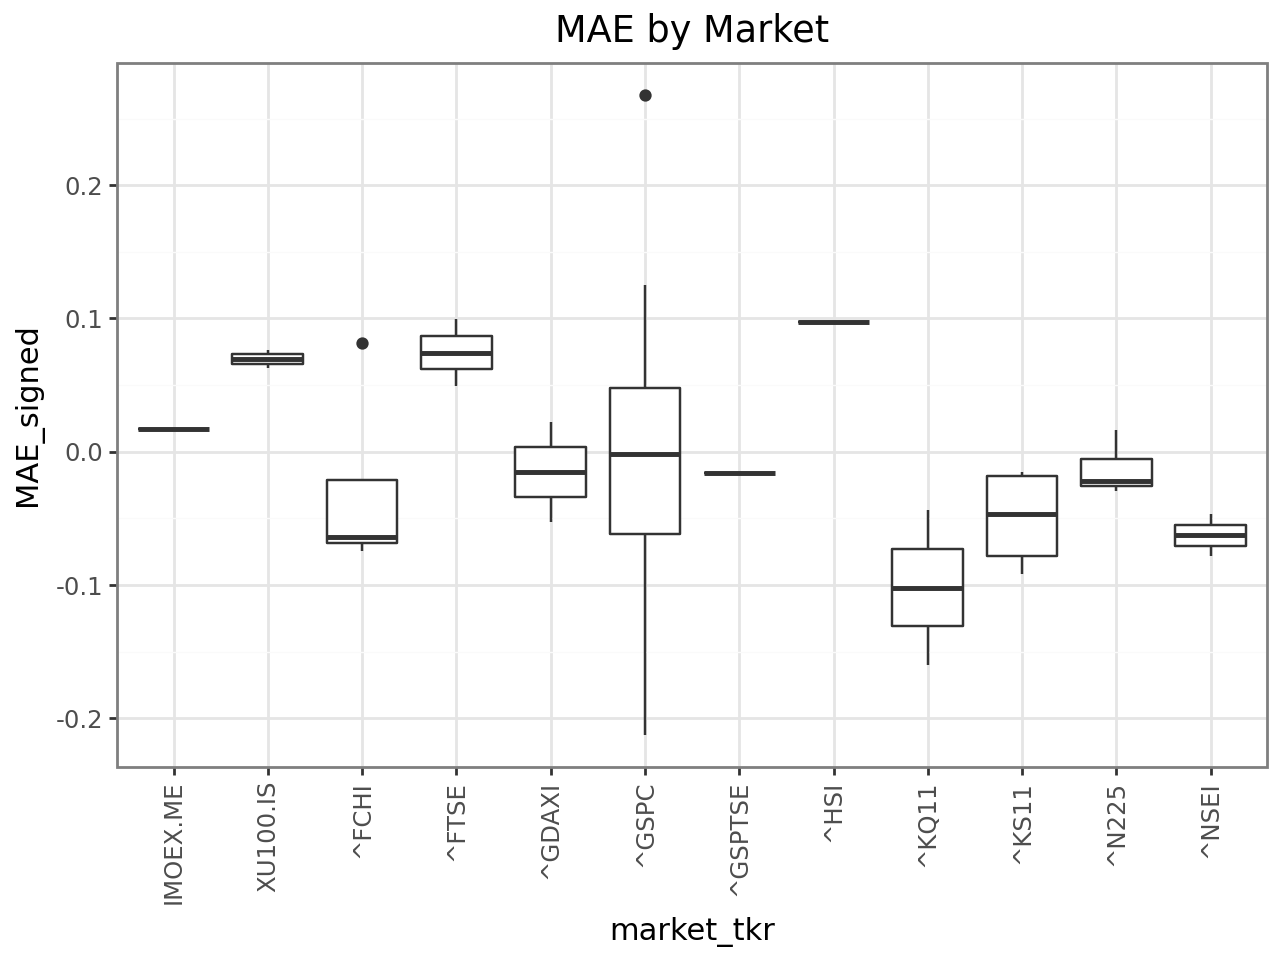

In [34]:
(
    ggplot(df, aes("market_tkr", "MAE_signed"))
    + geom_boxplot()
    + theme_bw()
    + theme(axis_text_x=element_text(rotation=90))
    + labs(title="MAE by Market")
)


##### TTR closer look

In [35]:
ttr_df = TTR_CACHE.join(df_ev_anal, on="ev_id", how="left")


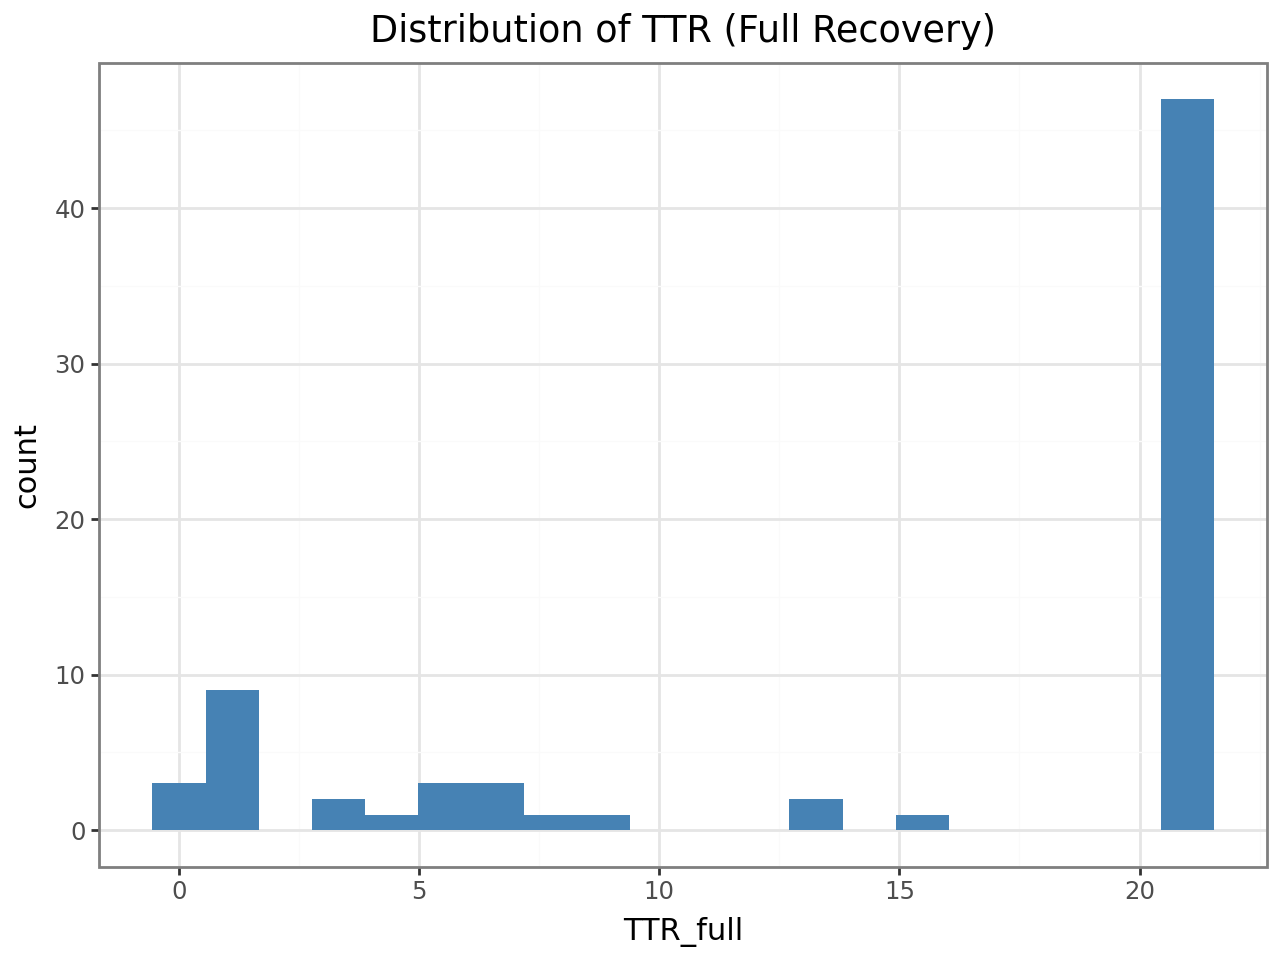

In [36]:
(
    ggplot(ttr_df, aes("TTR_full"))
    + geom_histogram(bins=20, fill="steelblue")
    + theme_bw()
    + labs(title="Distribution of TTR (Full Recovery)")
)


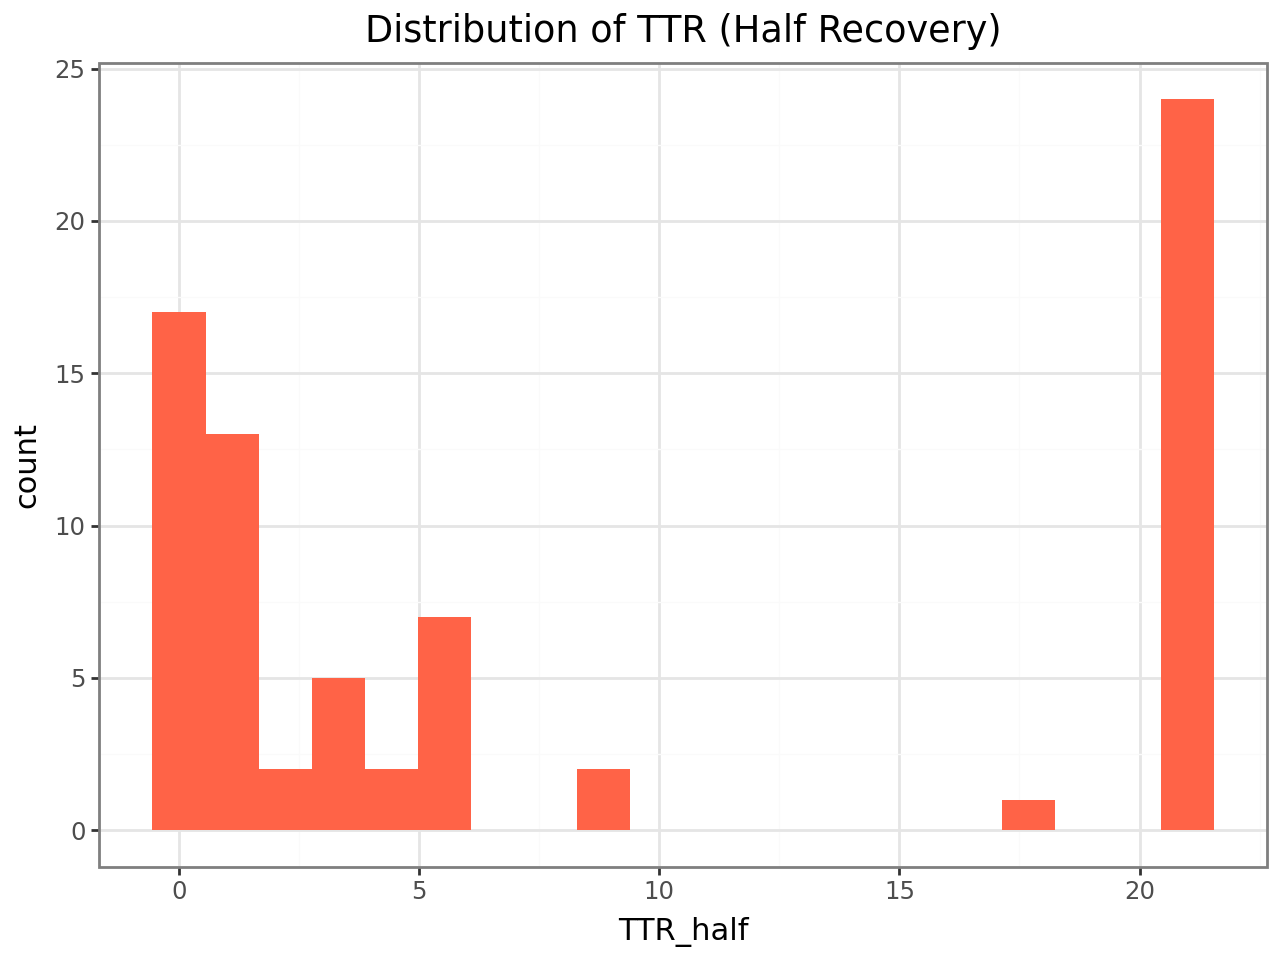

In [37]:
(
    ggplot(ttr_df, aes("TTR_half"))
    + geom_histogram(bins=20, fill="tomato")
    + theme_bw()
    + labs(title="Distribution of TTR (Half Recovery)")
)


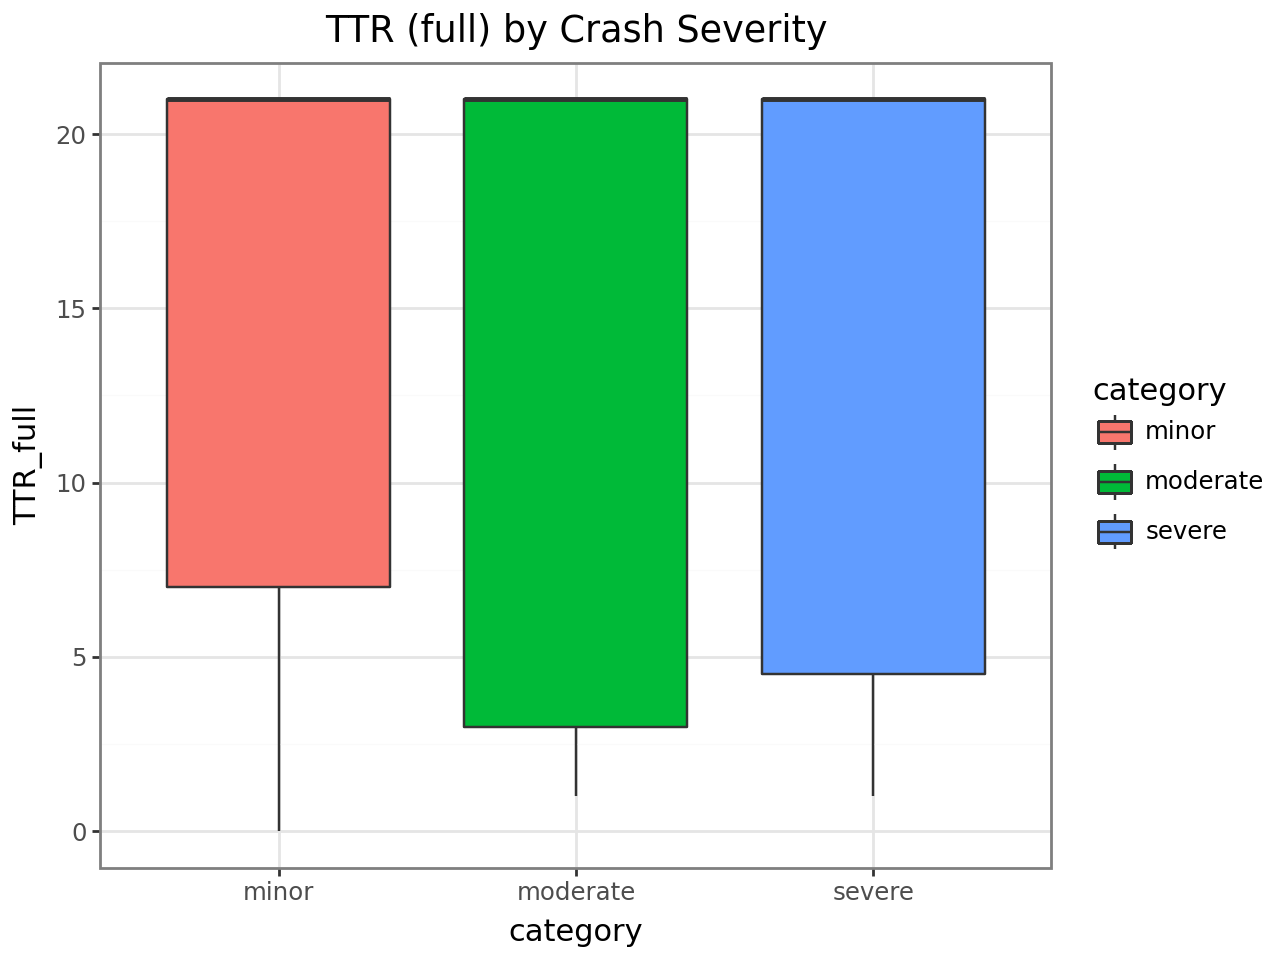

In [38]:
(
    ggplot(ttr_df, aes("category", "TTR_full", fill="category"))
    + geom_boxplot()
    + theme_bw()
    + labs(title="TTR (full) by Crash Severity")
)


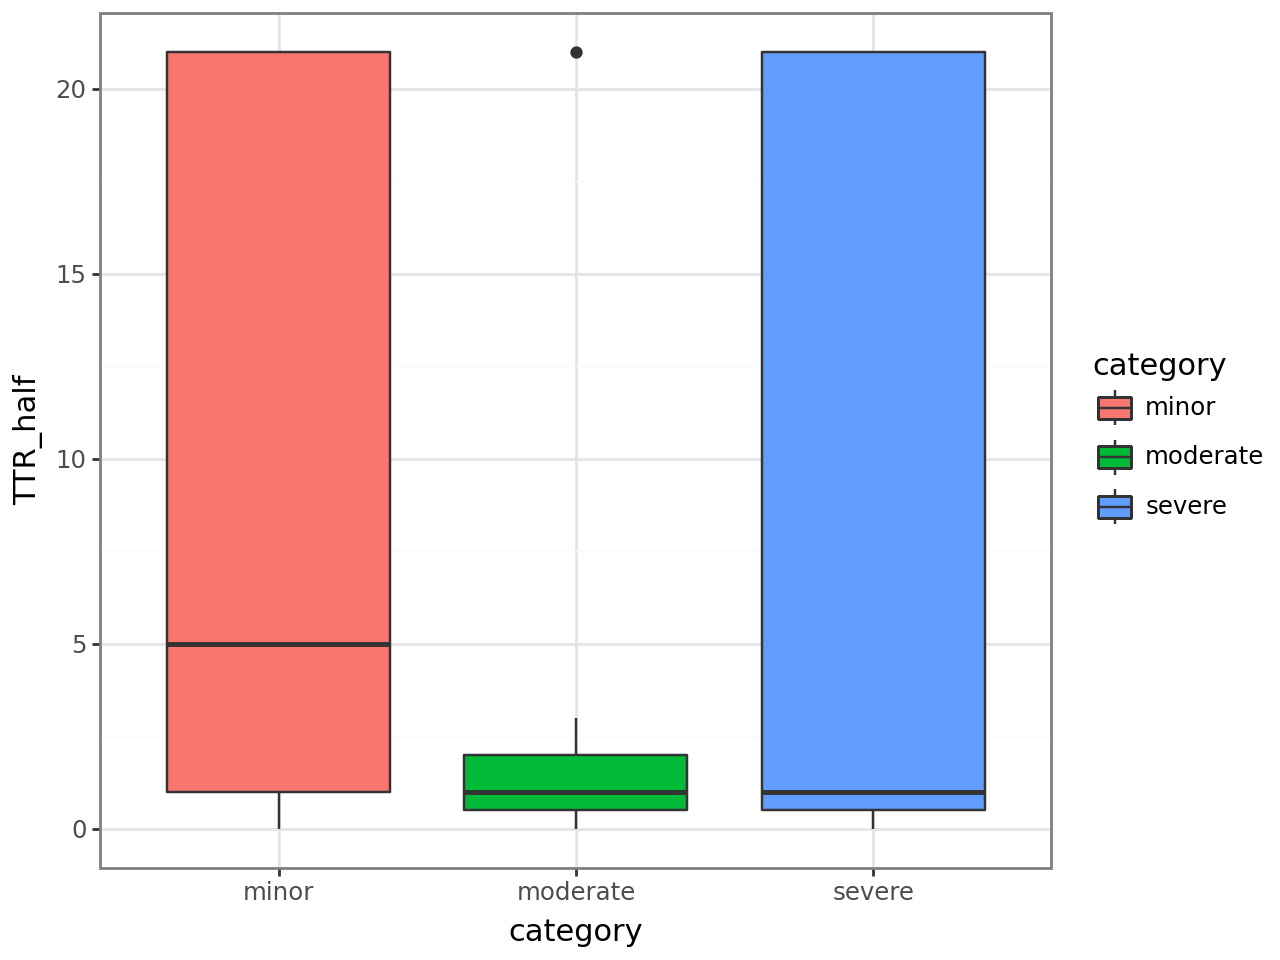

In [39]:
(
    ggplot(ttr_df, aes("category", "TTR_half", fill="category"))
    + geom_boxplot()
    + theme_bw()
)


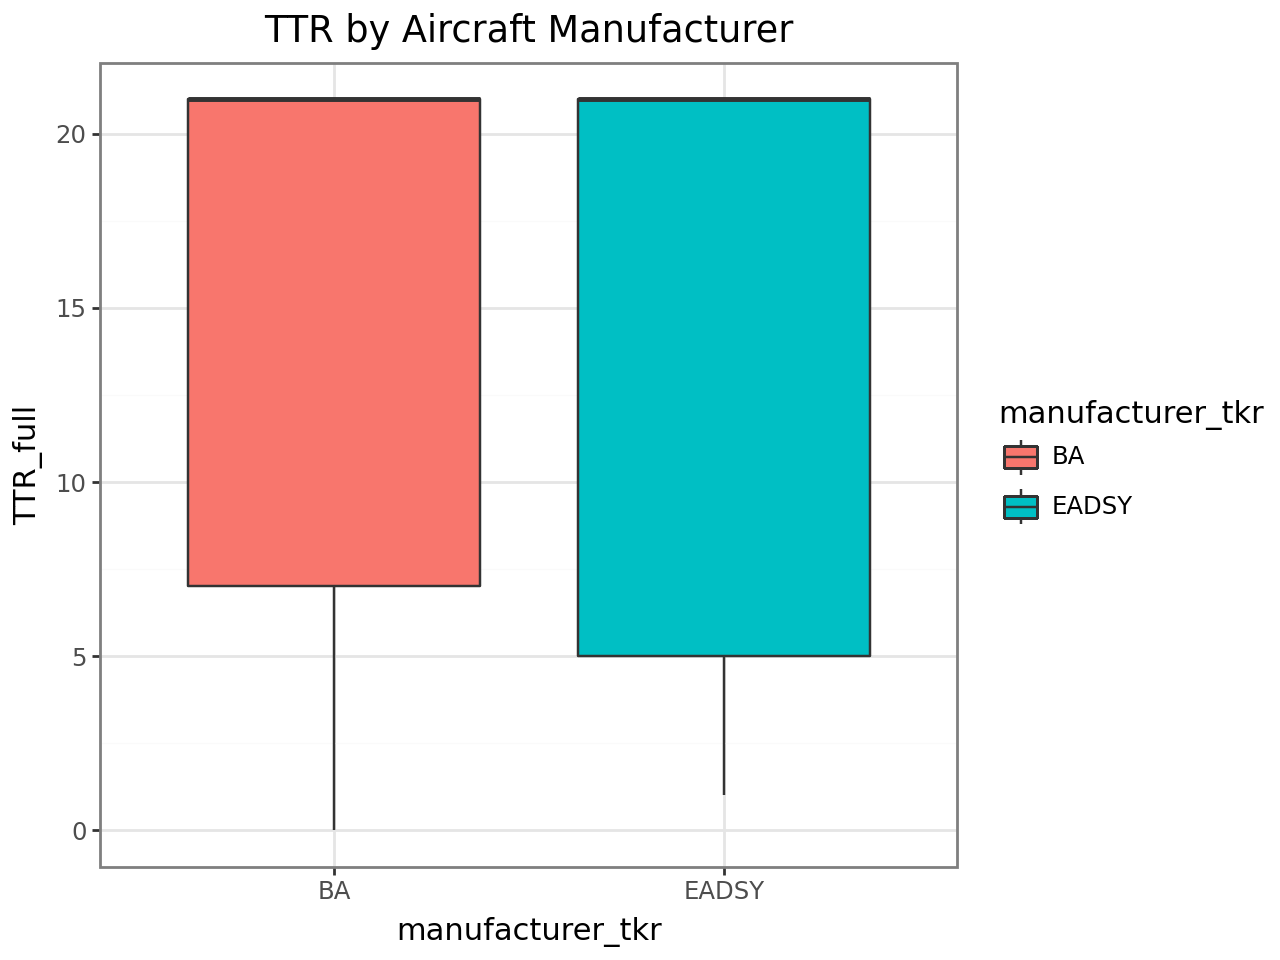

In [40]:
(
    ggplot(ttr_df, aes("manufacturer_tkr", "TTR_full", fill="manufacturer_tkr"))
    + geom_boxplot()
    + theme_bw()
    + labs(title="TTR by Aircraft Manufacturer")
)


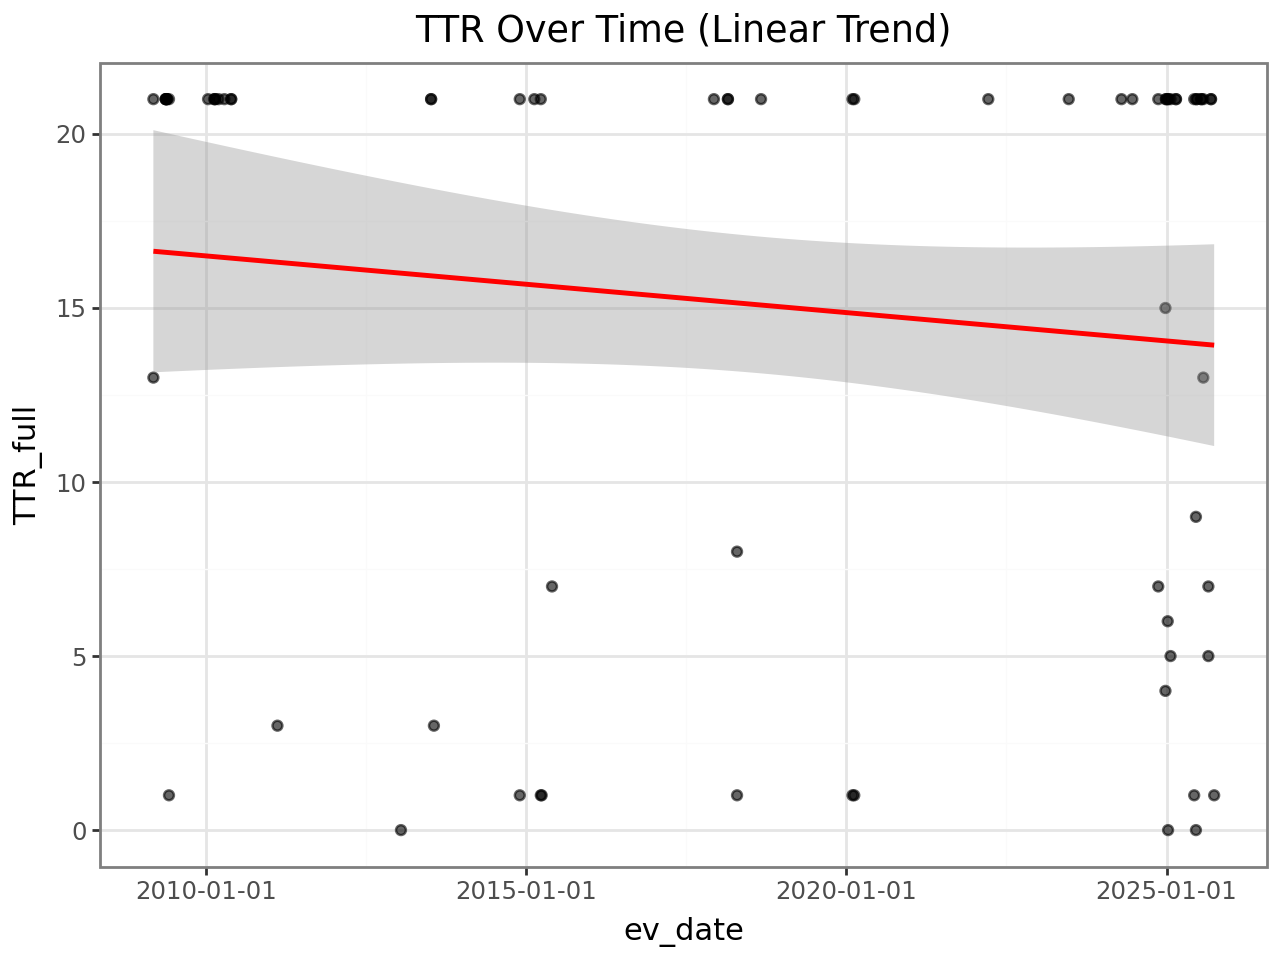

In [41]:
(
    ggplot(ttr_df, aes("ev_date", "TTR_full"))
    + geom_point(alpha=0.6)
    + geom_smooth(method="lm", color="red")
    + theme_bw()
    + labs(title="TTR Over Time (Linear Trend)")
)


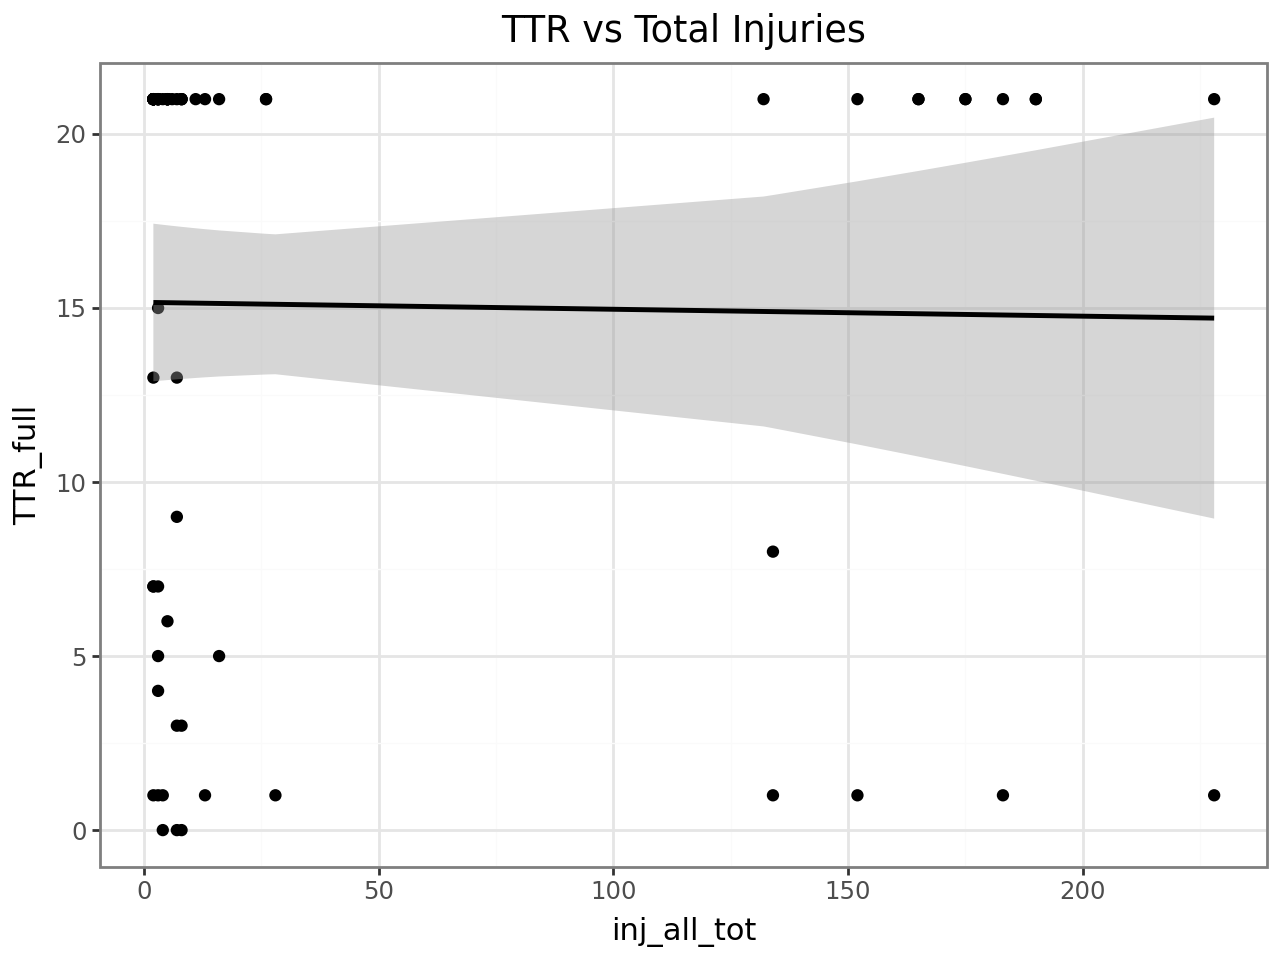

In [42]:
(
    ggplot(ttr_df, aes("inj_all_tot", "TTR_full"))
    + geom_point()
    + geom_smooth(method="lm")
    + theme_bw()
    + labs(title="TTR vs Total Injuries")
)


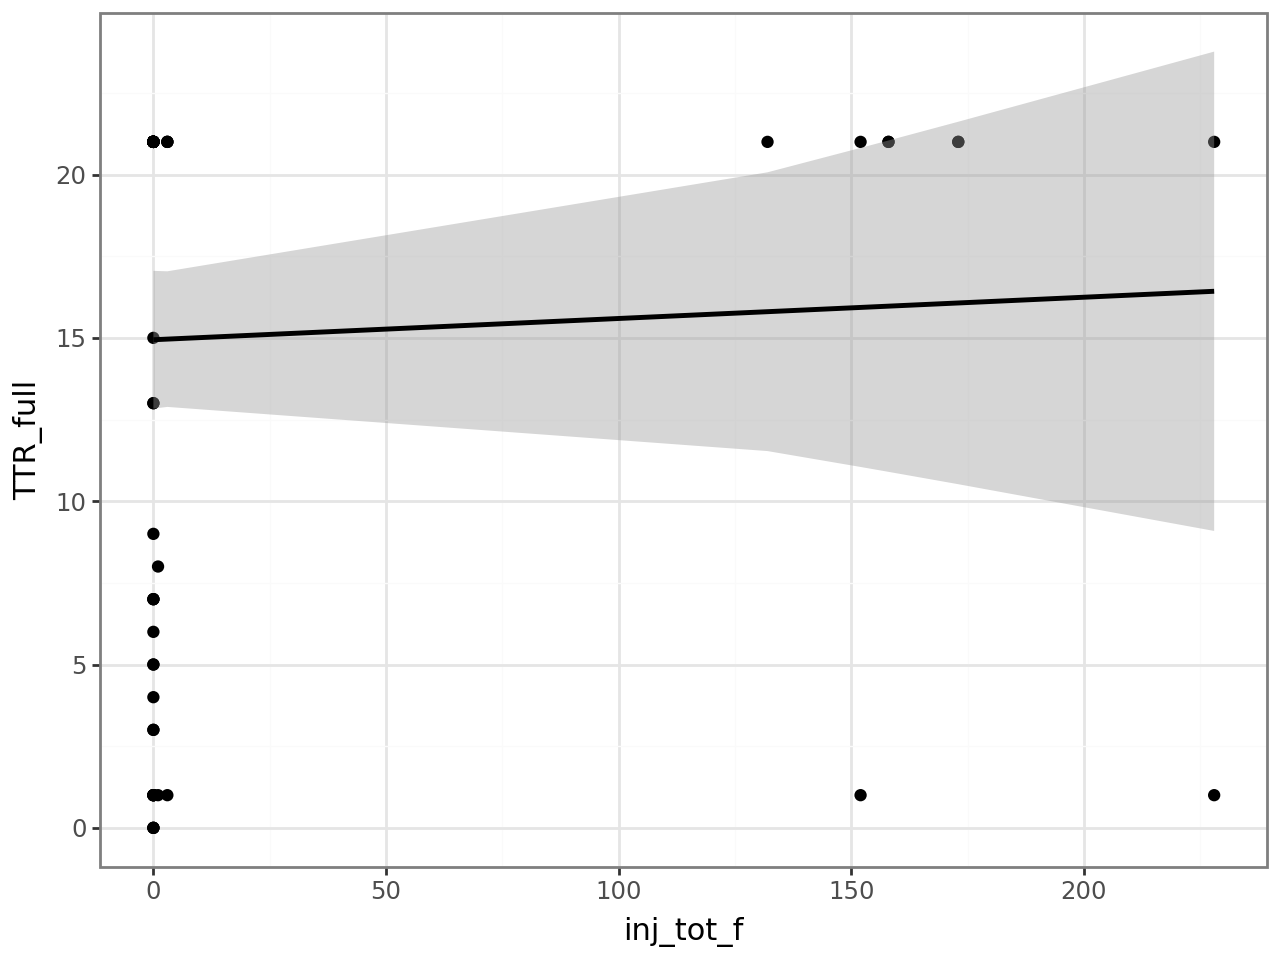

In [43]:
(
    ggplot(ttr_df, aes("inj_tot_f", "TTR_full"))
    + geom_point()
    + geom_smooth(method="lm")
    + theme_bw()
)


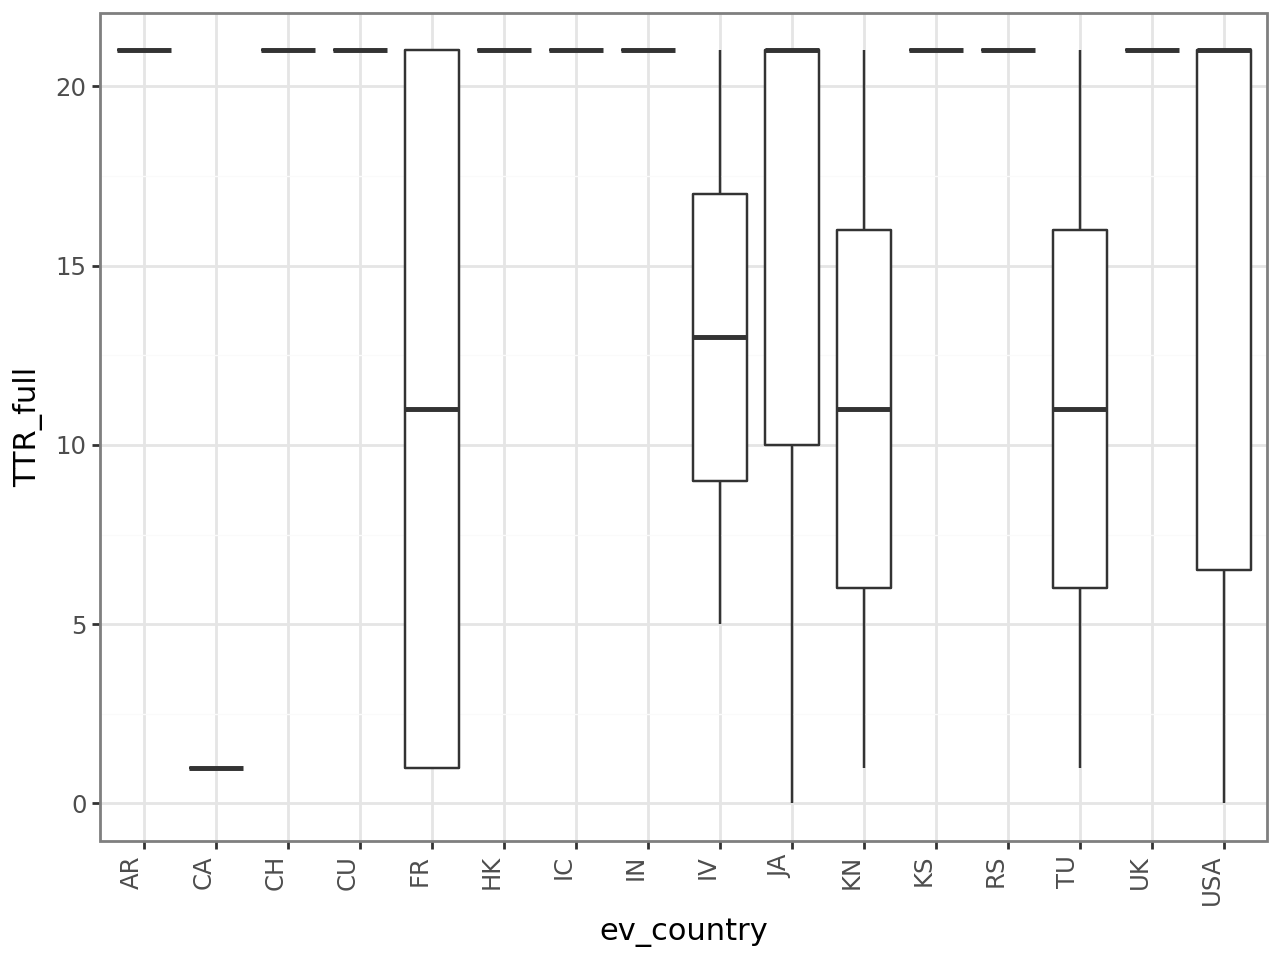

In [44]:
(
    ggplot(ttr_df, aes("ev_country", "TTR_full"))
    + geom_boxplot()
    + theme_bw()
    + theme(axis_text_x=element_text(rotation=90, hjust=1))
)


In [45]:
car = CAR_CACHE.join(
    df_ev_anal.select(["ev_id", "ev_date"]), on="ev_id", how="left"
).with_columns((pl.col("date") - pl.col("ev_date")).dt.total_days().alias("rel_day"))


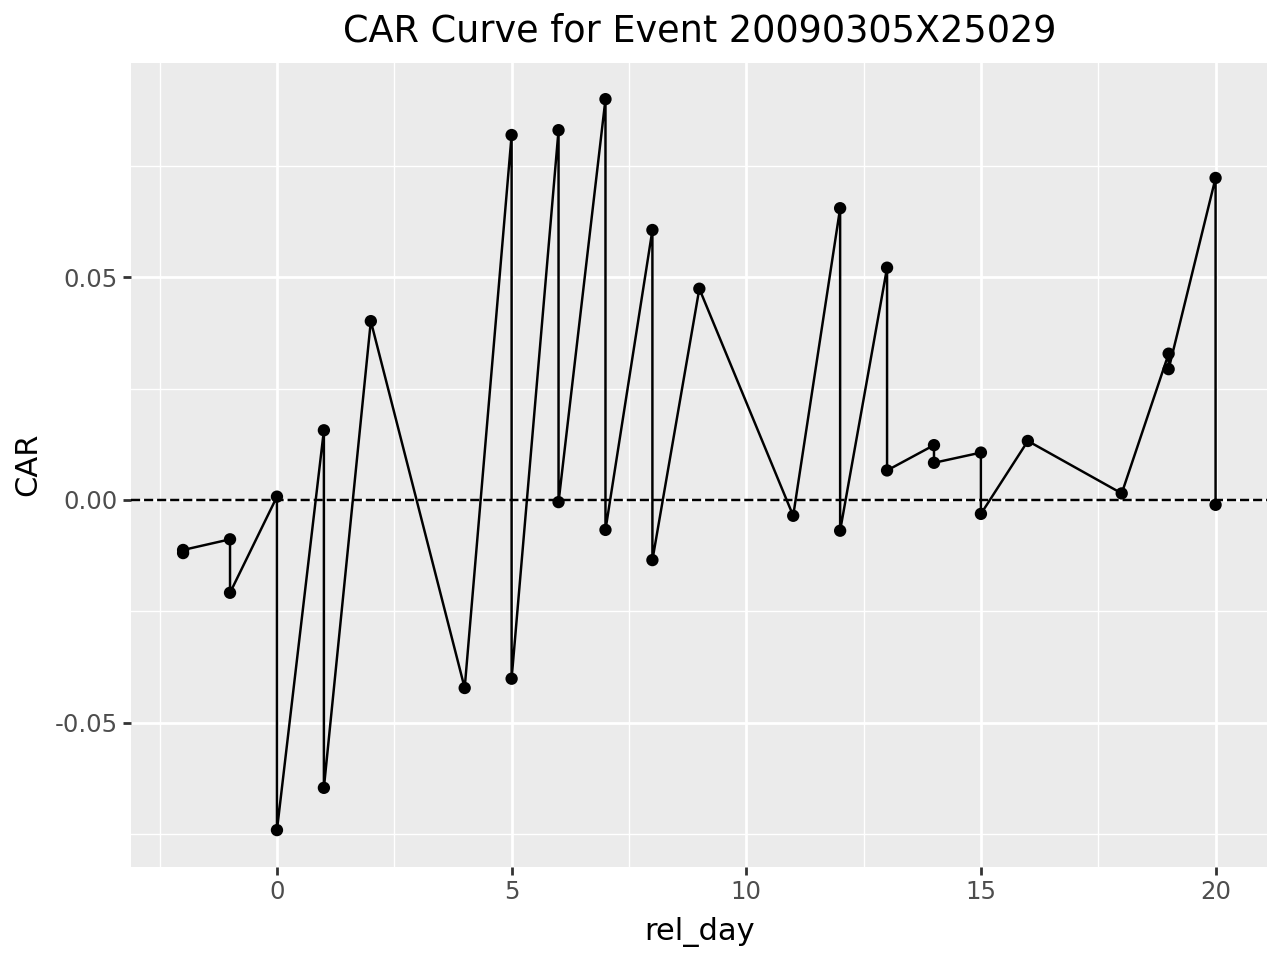

In [46]:
ev = "20090305X25029"

df_ev = car.filter(pl.col("ev_id") == ev)

(
    ggplot(df_ev, aes("rel_day", "CAR"))
    + geom_line()
    + geom_point()
    + geom_hline(yintercept=0, linetype="dashed")
    + labs(title=f"CAR Curve for Event {ev}")
)


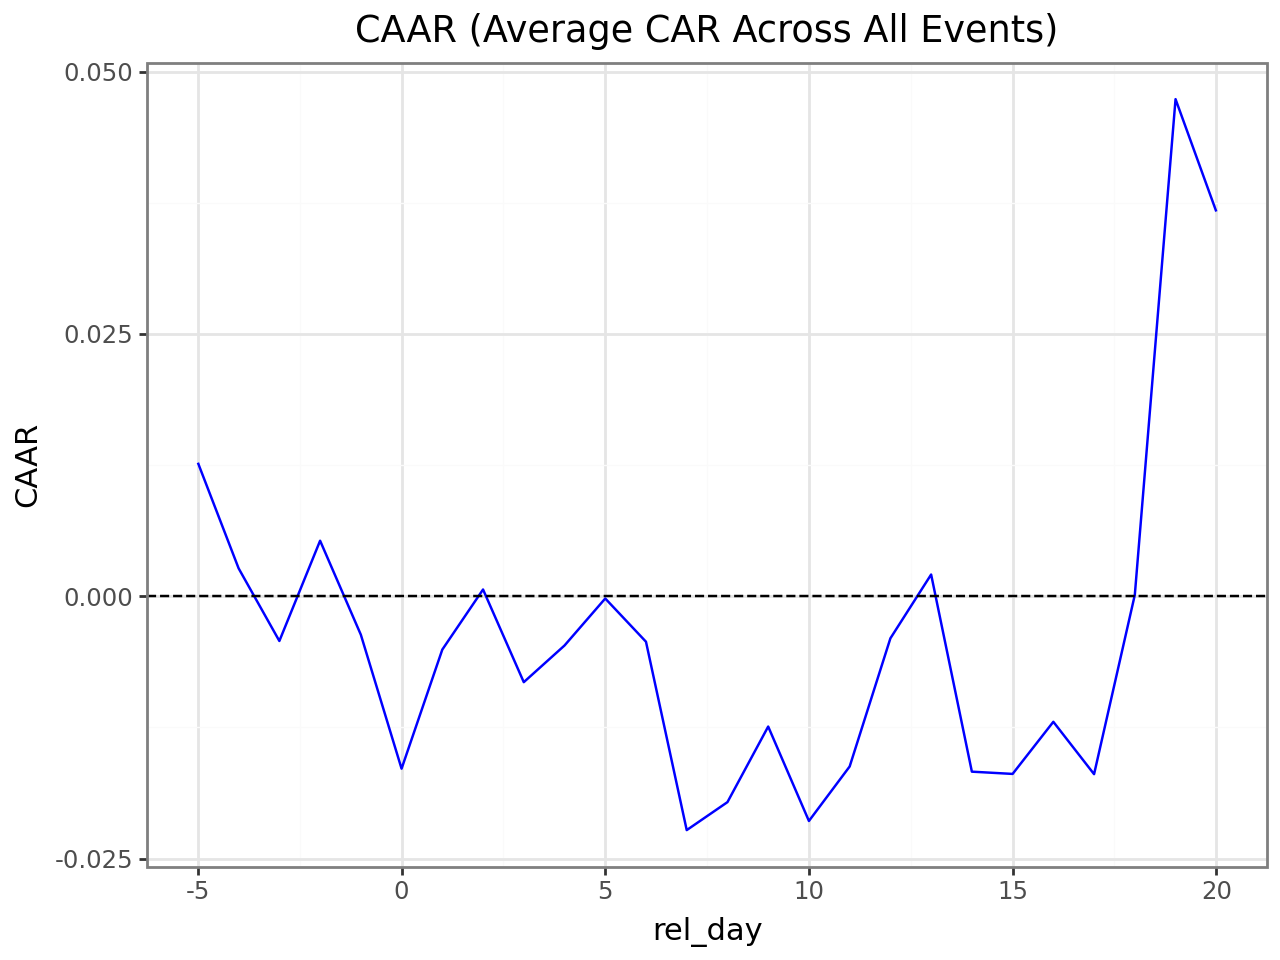

In [47]:
caar = car.group_by("rel_day").agg(pl.col("CAR").mean().alias("CAAR")).sort("rel_day")
(
    ggplot(caar, aes("rel_day", "CAAR"))
    + geom_line(color="blue")
    + geom_hline(yintercept=0, linetype="dashed")
    + theme_bw()
    + labs(title="CAAR (Average CAR Across All Events)")
)


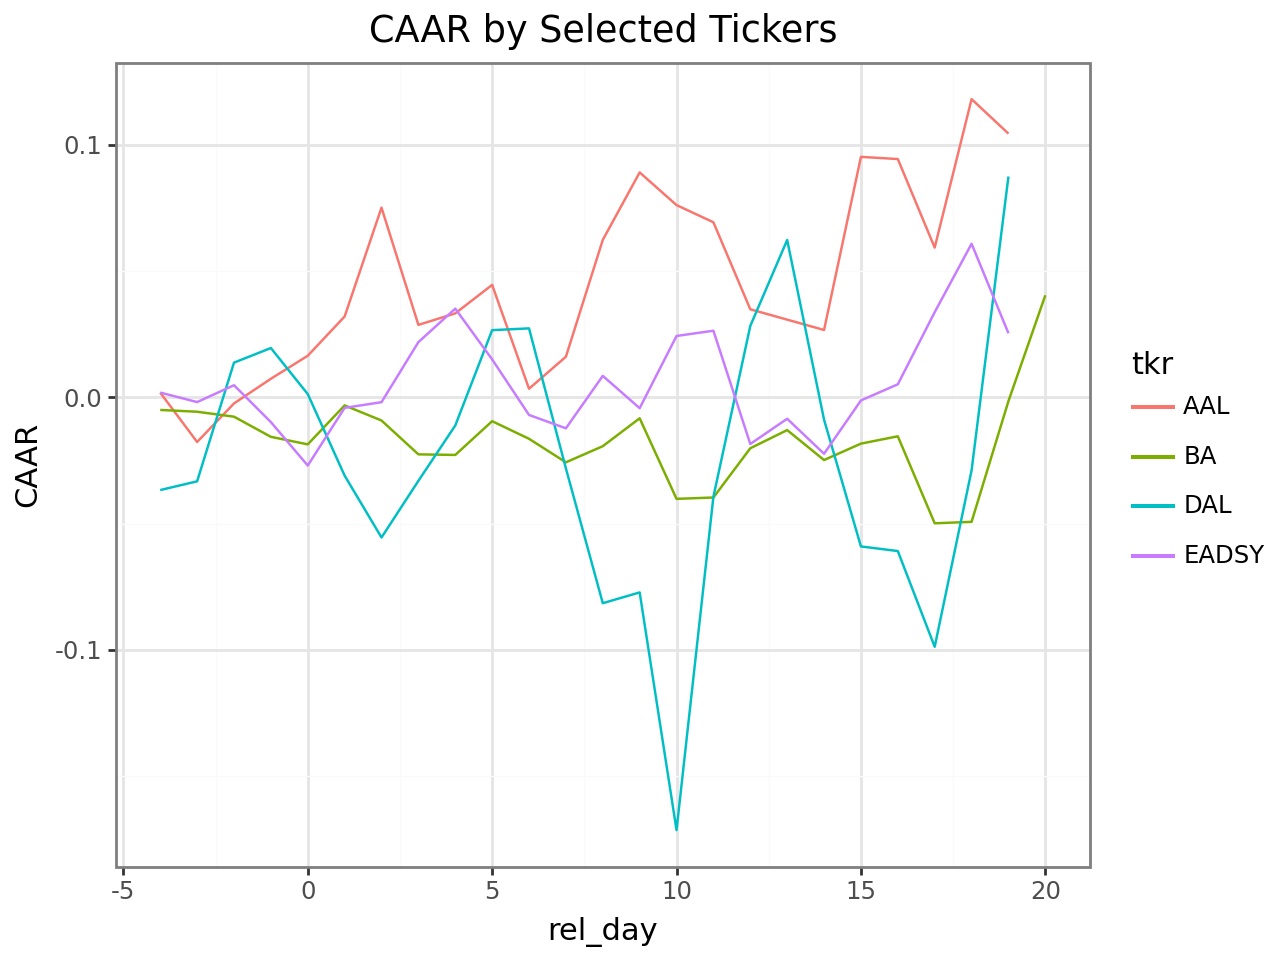

In [48]:
tickers = ["BA", "EADSY", "AAL", "DAL"]
df_sub = car.filter(pl.col("tkr").is_in(tickers))

caar_tkr = df_sub.group_by(["rel_day", "tkr"]).agg(pl.col("CAR").mean().alias("CAAR"))
(
    ggplot(caar_tkr, aes("rel_day", "CAAR", color="tkr"))
    + geom_line()
    + theme_bw()
    + labs(title="CAAR by Selected Tickers")
)


/tmp/ipykernel_2521/3682008627.py:3: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
/opt/base-uv/.venv/lib/python3.12/site-packages/plotnine/layer.py:293: PlotnineWarning: stat_boxplot : Removed 32 rows containing non-finite values.


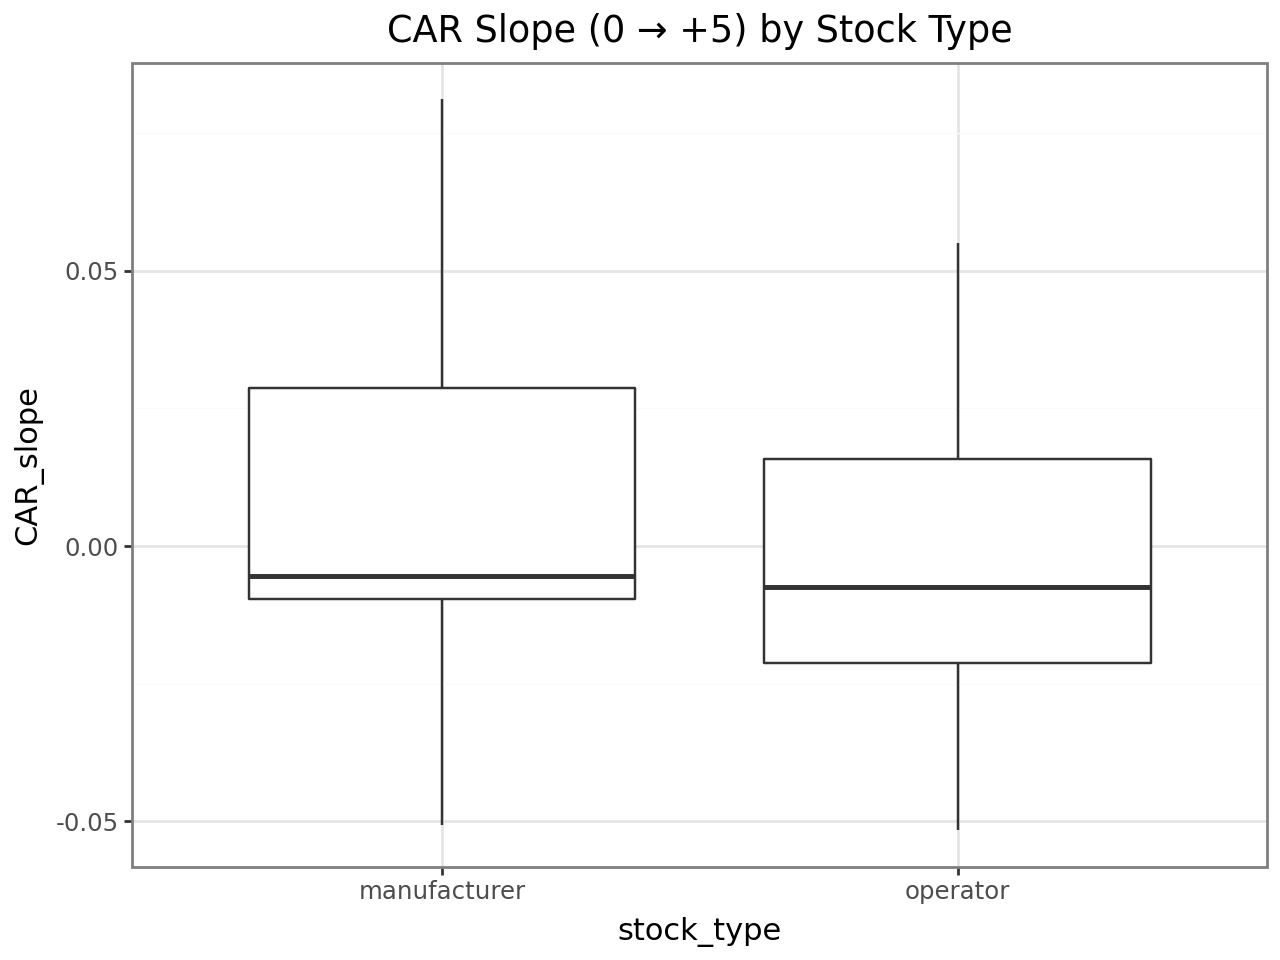

In [49]:
slope_df = (
    car.filter(pl.col("rel_day").is_in([0, 5]))
    .pivot(index=["ev_id", "tkr", "stock_type"], columns="rel_day", values="CAR")
    .with_columns((pl.col("5") - pl.col("0")).alias("CAR_slope"))
)
(
    ggplot(slope_df, aes("stock_type", "CAR_slope"))
    + geom_boxplot()
    + theme_bw()
    + labs(title="CAR Slope (0 → +5) by Stock Type")
)
